In [1]:
import posixpath
import numpy as np
import pandas as pd
import geopandas as gpd
import distances
import matplotlib.pyplot as plt
import scipy

## Load Fronts

In [2]:
data_root = "D:/OneDrive/Documents/Cours/4A/SFE/data/"

kh_fronts = gpd.read_file(posixpath.join(data_root, "KH-5_ARGON_fronts/KH-5_ARGON_fronts.shp")).to_crs(epsg=25833)
landsat_fronts = gpd.read_file(posixpath.join(data_root, "Landsat_MSS_fronts/Landsat_MSS_fronts.shp")).to_crs(epsg=25833)
npi_fronts = gpd.read_file(posixpath.join(data_root, "NPI_fronts/NPI_fronts.shp")).to_crs(epsg=25833)
all_fronts = pd.concat([npi_fronts, kh_fronts, landsat_fronts], ignore_index=True)
all_fronts.head()

,mission,timestamp,RGI60ID,RGI70ID,front_id,front_dir,geometry,image
0,NPI 1936-1938 aerial survey,1936-01-01,RGI60-07.00006,RGI2000-v7.0-G-07-00787,77,NW,"LINESTRING (532543.309 8544051.053, 532636.725...",NaN
1,NPI 1936-1938 aerial survey,1936-01-01,RGI60-07.00025,RGI2000-v7.0-G-07-01384,161,S,"LINESTRING (688874.291 8815732.222, 688441.142...",NaN
2,NPI 1936-1938 aerial survey,1936-01-01,RGI60-07.00035,RGI2000-v7.0-G-07-01365,176,E,"LINESTRING (626236.343 8902937.128, 626351.396...",NaN
3,NPI 1936-1938 aerial survey,1936-01-01,RGI60-07.00036,RGI2000-v7.0-G-07-01363,177,E,"LINESTRING (610107.299 8911853.037, 610139.55 ...",NaN
4,NPI 1936-1938 aerial survey,1936-01-01,RGI60-07.01449,RGI2000-v7.0-G-07-01343,144,NW,"LINESTRING (581931.237 8893586.913, 581984.338...",NaN


In [3]:
print(len(all_fronts.RGI70ID.value_counts()), "glaciers observed")
print(len(all_fronts.front_id.value_counts()), "fronts observed")

167 glaciers observed
185 fronts observed


# OLD

## Results w/ manual distance

In [2]:
def get_year(timestamp):
    return timestamp.year

results = pd.DataFrame(
    [],
    columns = ["front_id", "year_1", "year_2", "distance"]
)
skip_count_len = 0
skip_count_dir = 0
total_count = 0
years = [1962, 1963, 1976, 1978]

for front in all_fronts.front_id.unique():
    # compare observations from any year to fronts from any other year, for a specific front.
    for i_year in range(len(years) - 1):
        year = years[i_year]
        fronts = all_fronts.loc[all_fronts.front_id == front].loc[all_fronts.timestamp.apply(get_year) == year]
        for i_other_year in range(i_year + 1, len(years)):
            other_year = years[i_other_year]
            other_fronts = all_fronts.loc[all_fronts.front_id == front].loc[all_fronts.timestamp.apply(get_year) == other_year]
            
            dists = []
            # compare all the observations between them
            for k in range(len(fronts.geometry)):
                for l in range(len(other_fronts.geometry)):
                    front1 = fronts.geometry.iloc[k]
                    front2 = other_fronts.geometry.iloc[l]
                    dir_1 = fronts.front_dir.iloc[k]
                    dir_2 = other_fronts.front_dir.iloc[l]
                    # print(front) # to identify the fronts that have different flow directions.
                    try:
                        dist, e = distances.distance(front1, front2, dir_1, dir_2)
                        if dist is not None: # recall: distance returns None if the lengths of the fronts are too different
                            dists.append(dist)
                        elif e == 1:
                            skip_count_len += 1
                        elif e == 2:
                            skip_count_dir += 1
                    except AssertionError:
                        skip_count_dir += 1
                    total_count += 1
            
            if not dists == []:
                # horrible hack to load an array as a value in a DataFrame
                results_i = pd.DataFrame(
                    [[front, year, other_year, np.array(dists)]],
                    columns=["front_id", "year_1", "year_2", "distance"]
                )      
            else: # load None instead of a list of distances
                results_i = pd.DataFrame(
                    [[front, year, other_year, None]],
                    columns=["front_id", "year_1", "year_2", "distance"]
                )
            results = pd.concat([results, results_i])
            
print(f"Skipped {skip_count_len + skip_count_dir} ({skip_count_dir} direction and {skip_count_len} length) comparisons out of {total_count}.")
results.reset_index(drop=True, inplace=True)
results = results.dropna().reset_index(drop=True)
results

NameError: name 'all_fronts' is not defined

In [ ]:
uncertainties = pd.read_csv("./uncertainties_manual.csv", dtype={"year_1": int, "year_2": int})
uncertainties.loc[:, "years"] = uncertainties.loc[:, ["year_1", "year_2"]].apply(lambda x: (x.iloc[0], x.iloc[1]), axis=1)
uncertainties

,year_1,year_2,sigma_dist,2_sigma_dist,3_sigma_dist,years
0,1962,1962,709.935208,1419.870417,2129.805625,"(1962, 1962)"
1,1962,1963,545.710546,1091.421092,1637.131638,"(1962, 1963)"
2,1962,1976,510.909973,1021.819945,1532.729918,"(1962, 1976)"
3,1962,1978,511.476295,1022.952589,1534.428884,"(1962, 1978)"
4,1963,1963,302.641702,605.283405,907.925107,"(1963, 1963)"
5,1963,1976,234.138848,468.277695,702.416543,"(1963, 1976)"
6,1963,1978,235.372046,470.744092,706.116138,"(1963, 1978)"
7,1976,1976,134.350288,268.700577,403.050865,"(1976, 1976)"
8,1976,1978,136.488095,272.976189,409.464284,"(1976, 1978)"


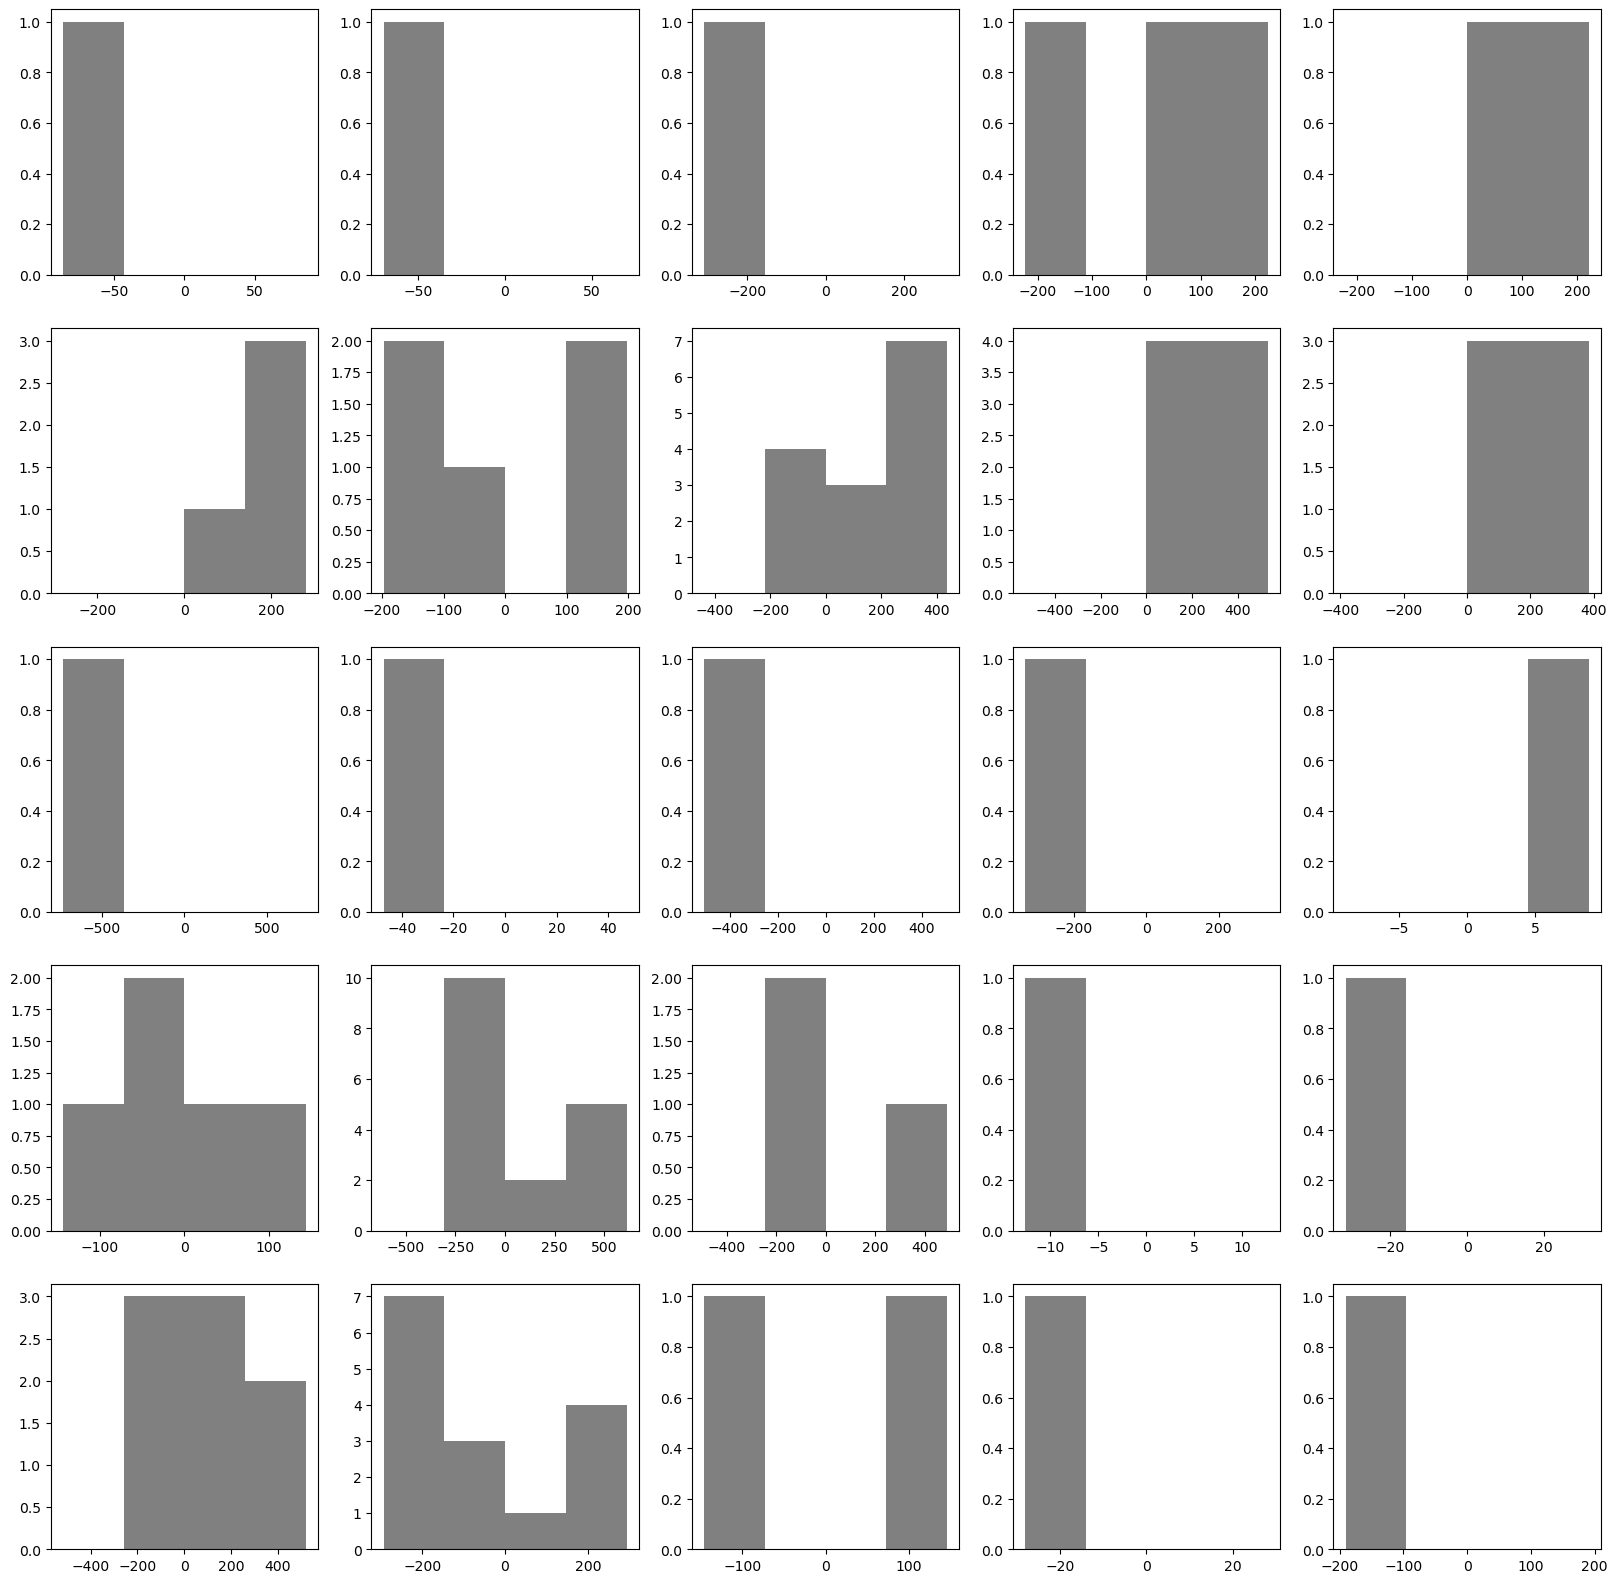

In [ ]:
fig, axs = plt.subplots(ncols=5, nrows=5, figsize=[20, 20])
c = 0
for i in range(len(results)):
    if len(results.distance[i]) > 1:
        if c < 25:
            axs[c//5, c%5].hist(results.distance[i], bins=np.linspace(-np.abs(results.distance[i].max()), np.abs(results.distance[i].max()), 5), color="gray")
        c += 1

In [ ]:
results.loc[:, "mean_distance"] = results.distance.apply(lambda x: np.array(x).mean())
results.loc[:, "uncertainty"] = results.loc[:, ["year_1", "year_2"]].apply(lambda x: uncertainties.loc[(uncertainties.year_1 == x.iloc[0]) & (uncertainties.year_2 == x.iloc[1]), "2_sigma_dist"].values[0], axis=1)

# not necessary but easier to control results : put the years in a single column. 
results.loc[:, "years"] = results.loc[:, ["year_1", "year_2"]].apply(lambda x: (x.iloc[0], x.iloc[1]), axis=1)
results = results[["front_id", "year_1", "year_2", "years", "distance", "mean_distance", "uncertainty"]]

results

,front_id,year_1,year_2,years,distance,mean_distance,uncertainty
0,4,1962,1963,"(1962, 1963)","[-86.23007513843609, -396.32188237109665]",-241.275979,1091.421092
1,4,1962,1976,"(1962, 1976)","[-1450.7132367907936, -1511.82316731564, -70.0...",-924.789543,1021.819945
2,4,1963,1976,"(1963, 1976)","[-422.5270542819276, -470.5395858628364, -310....",-664.223629,468.277695
3,25,1962,1963,"(1962, 1963)","[52.934303303832884, -308.1062720617464, 223.5...",-39.310605,1091.421092
4,25,1962,1976,"(1962, 1976)","[76.82899443702789, 220.5166627894711]",148.672829,1021.819945
...,...,...,...,...,...,...,...
434,87,1976,1978,"(1976, 1978)",[-91.97451945462406],-91.974519,272.976189
435,82,1976,1978,"(1976, 1978)",[-153.44472935472436],-153.444729,272.976189
436,66,1976,1978,"(1976, 1978)",[-72.56704667293884],-72.567047,272.976189
437,72,1976,1978,"(1976, 1978)",[-33.72669053388882],-33.726691,272.976189


In [ ]:
# horrible way to plot a summary of the results, but I could not find better.
results_overview = pd.DataFrame(
    [],
    columns=["years", "uncertainty", "count"]
)
results_overview.loc[:, "years"] = results.years.unique()
results_overview.loc[:, "uncertainty"] = results.uncertainty.unique()
results_overview.loc[:, "count"] = results.years.value_counts().values
results_overview

,years,uncertainty,count
0,"(1962, 1963)",1091.421092,100
1,"(1962, 1976)",1021.819945,94
2,"(1963, 1976)",468.277695,68
3,"(1963, 1978)",470.744092,65
4,"(1976, 1978)",272.976189,62
5,"(1962, 1978)",1022.952589,50


62 -25.64493951798229 202.68955163617233
100 -144.3029461553655 577.9798141277005
68 -103.46106983241184 714.7724608579525
65 -242.87406537842466 638.818181857793
50 -195.08917853911626 739.0742261257744
94 -56.48980003531667 149.42638623089078


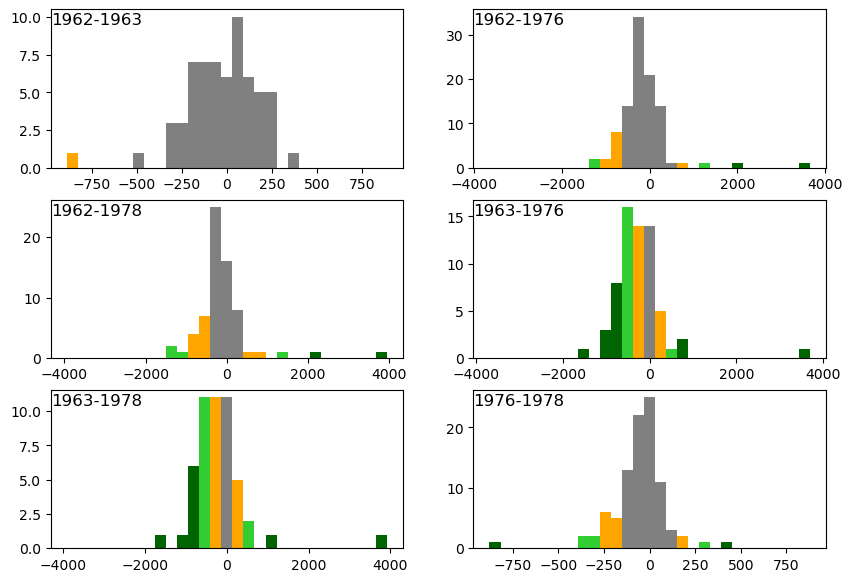

In [ ]:
fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(10, 7))

color_sigma = "orange"
color_2_sigma = "limegreen"
color_3_sigma = "darkgreen"
nbins = 30

years = (1962, 1963)
d = results.loc[results.years == years].mean_distance
N, bins, patches = axs[0, 0].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties.loc[uncertainties.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2  # shift bins to the center
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[0, 0].set_title(f"{years[0]}-{years[1]}", y=0.85, loc="left")
print(d.shape[0], d.mean(), d.std())
        
years = (1962, 1976)
d = results.loc[results.years == years].mean_distance
N, bins, patches = axs[0, 1].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties.loc[uncertainties.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[0, 1].set_title(f"{years[0]}-{years[1]}", y=0.85, loc="left")
print(d.shape[0], d.mean(), d.std())
        
years = (1962, 1978)
d = results.loc[results.years == years].mean_distance
N, bins, patches = axs[1, 0].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties.loc[uncertainties.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[1, 0].set_title(f"{years[0]}-{years[1]}", y=0.85, loc="left")
print(d.shape[0], d.mean(), d.std())
        
years = (1963, 1976)
d = results.loc[results.years == years].mean_distance
N, bins, patches = axs[1, 1].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties.loc[uncertainties.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[1, 1].set_title(f"{years[0]}-{years[1]}", y=0.85, loc="left")
print(d.shape[0], d.mean(), d.std())
        
years = (1963, 1978)
d = results.loc[results.years == years].mean_distance
N, bins, patches = axs[2, 0].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties.loc[uncertainties.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[2, 0].set_title(f"{years[0]}-{years[1]}", y=0.85, loc="left")
print(d.shape[0], d.mean(), d.std())
        
years = (1976, 1978)
d = results.loc[results.years == years].mean_distance
N, bins, patches = axs[2, 1].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties.loc[uncertainties.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[2, 1].set_title(f"{years[0]}-{years[1]}", y=0.85, loc="left")
print(d.shape[0], d.mean(), d.std())
fig.savefig("images/results_distances_distributions.png", bbox_inches="tight")

62 -25.64493951798229 202.68955163617233
100 -144.3029461553655 577.9798141277005
68 -103.46106983241184 714.7724608579525
65 -242.87406537842466 638.818181857793
50 -195.08917853911626 739.0742261257744
94 -56.48980003531667 149.42638623089078


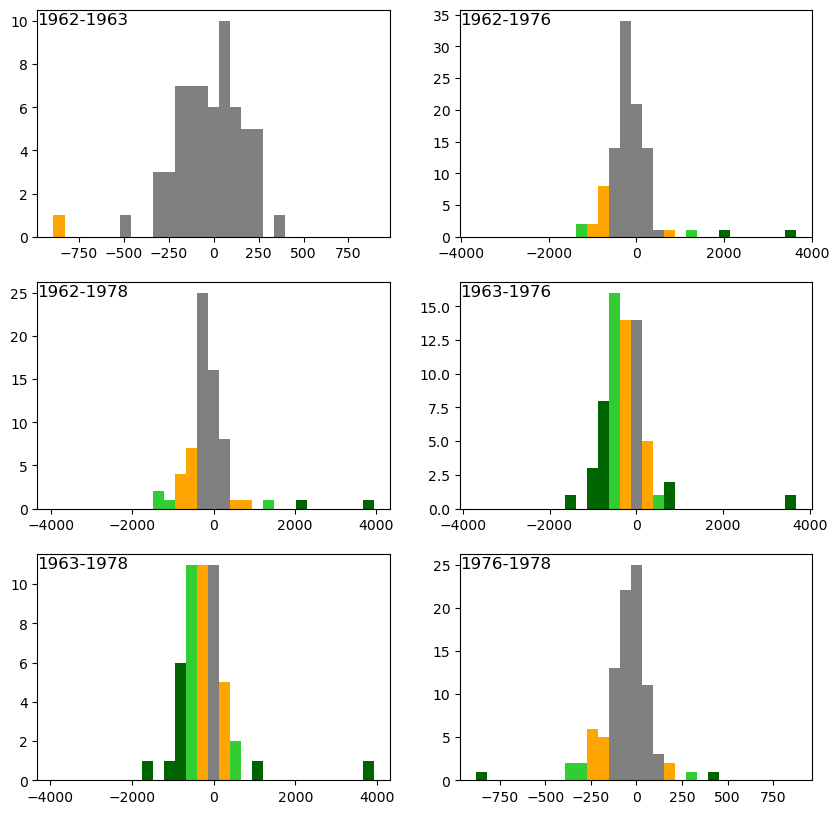

In [ ]:
fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(10, 10))

color_sigma = "orange"
color_2_sigma = "limegreen"
color_3_sigma = "darkgreen"
nbins = 30

years = (1962, 1963)
d = results.loc[results.years == years].mean_distance
N, bins, patches = axs[0, 0].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties.loc[uncertainties.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2  # shift bins to the center
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[0, 0].set_title(f"{years[0]}-{years[1]}", y=0.9, loc="left")
print(d.shape[0], d.mean(), d.std())
        
years = (1962, 1976)
d = results.loc[results.years == years].mean_distance
N, bins, patches = axs[0, 1].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties.loc[uncertainties.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[0, 1].set_title(f"{years[0]}-{years[1]}", y=0.9, loc="left")
print(d.shape[0], d.mean(), d.std())
        
years = (1962, 1978)
d = results.loc[results.years == years].mean_distance
N, bins, patches = axs[1, 0].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties.loc[uncertainties.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[1, 0].set_title(f"{years[0]}-{years[1]}", y=0.9, loc="left")
print(d.shape[0], d.mean(), d.std())
        
years = (1963, 1976)
d = results.loc[results.years == years].mean_distance
N, bins, patches = axs[1, 1].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties.loc[uncertainties.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[1, 1].set_title(f"{years[0]}-{years[1]}", y=0.9, loc="left")
print(d.shape[0], d.mean(), d.std())
        
years = (1963, 1978)
d = results.loc[results.years == years].mean_distance
N, bins, patches = axs[2, 0].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties.loc[uncertainties.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[2, 0].set_title(f"{years[0]}-{years[1]}", y=0.9, loc="left")
print(d.shape[0], d.mean(), d.std())
        
years = (1976, 1978)
d = results.loc[results.years == years].mean_distance
N, bins, patches = axs[2, 1].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties.loc[uncertainties.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[2, 1].set_title(f"{years[0]}-{years[1]}", y=0.9, loc="left")
print(d.shape[0], d.mean(), d.std())
fig.savefig("images/results_distances_distributions_big.png", bbox_inches="tight")

In [ ]:
# list of surges and retreats

surges = pd.DataFrame(
    [],
    columns=["front_id", "years", "mean_distance", "uncertainty"]
)

retreats = pd.DataFrame(
    [],
    columns=["front_id", "years", "mean_distance", "uncertainty"]
)

for years in [(1962, 1963), (1962, 1976), (1962, 1978), (1963, 1976), (1963, 1978), (1976, 1978)]:
    # print("years :", years)
    sigma = uncertainties.loc[uncertainties.years == years]["sigma_dist"].values[0]
    res = results.where(results.loc[results.years == years, "mean_distance"].apply(lambda x: np.abs(x) >= 2 * sigma)).dropna().loc[:, ["front_id", "years", "mean_distance", "uncertainty"]]
    # print(res)
    surges_1 = res.where(res.mean_distance.apply(lambda x: x >= 0)).dropna()
    retreats_1 = res.where(res.mean_distance.apply(lambda x: x < 0)).dropna()
    if not surges_1.empty:
        surges = pd.concat([surges, surges_1])
    if not retreats_1.empty:
        retreats = pd.concat([retreats, retreats_1])
        
surges

C:\Users\loris\AppData\Local\Temp\ipykernel_4536\2778544960.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  surges = pd.concat([surges, surges_1])
C:\Users\loris\AppData\Local\Temp\ipykernel_4536\2778544960.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  retreats = pd.concat([retreats, retreats_1])


,front_id,years,mean_distance,uncertainty
253,122,"(1962, 1976)",3652.623886,1021.819945
307,121,"(1962, 1976)",1962.144474,1021.819945
350,123,"(1962, 1976)",1312.976490,1021.819945
254,122,"(1962, 1978)",3943.133563,1022.952589
308,121,"(1962, 1978)",2084.629828,1022.952589
351,123,"(1962, 1978)",1280.833637,1022.952589
116,56,"(1963, 1976)",719.102820,468.277695
193,91,"(1963, 1976)",626.482327,468.277695
255,122,"(1963, 1976)",3689.328406,468.277695
401,93,"(1963, 1976)",750.657229,468.277695


In [ ]:
retreats

,front_id,years,mean_distance,uncertainty
42,37,"(1962, 1976)",-1211.339623,1021.819945
396,73,"(1962, 1976)",-1241.139226,1021.819945
43,37,"(1962, 1978)",-1436.924820,1022.952589
269,154,"(1962, 1978)",-1316.596948,1022.952589
357,109,"(1962, 1978)",-1147.300764,1022.952589
2,4,"(1963, 1976)",-664.223629,468.277695
10,28,"(1963, 1976)",-909.392141,468.277695
44,37,"(1963, 1976)",-1405.024328,468.277695
50,38,"(1963, 1976)",-628.615979,468.277695
65,41,"(1963, 1976)",-574.854364,468.277695


In [ ]:
# list of all fronts that either surged or retreated with >95% accuracy
len(surges.front_id.unique()), surges.front_id.unique(), len(retreats.front_id.unique()), retreats.front_id.unique()

(8,
 array([122, 121, 123, 56, 91, 93, 120, 165], dtype=object),
 32,
 array([37, 73, 154, 109, 4, 28, 38, 41, 50, 51, 52, 53, 54, 58, 59, 141,
        161, 139, 140, 142, 160, 42, 95, 96, 97, 49, 2, 61, 76, 74, 93, 89],
       dtype=object))

## Results w/ box distance

In [ ]:
boxes = gpd.read_file(posixpath.join(data_root, "boxes/boxes.shp")).to_crs(epsg=25833)
boxes.head()

,front_id,front_dir,RGI60ID,RGI70ID,geometry
0,1,NE,RGI60-07.01494,RGI2000-v7.0-G-07-00054,"POLYGON ((448958.093 8831407.133, 451132.965 8..."
1,2,NE,RGI60-07.00791,RGI2000-v7.0-G-07-01223,"POLYGON ((448556.464 8831393.624, 447609.196 8..."
2,3,E,RGI60-07.00777,RGI2000-v7.0-G-07-01225,"POLYGON ((446223.949 8833013.329, 449012.234 8..."
3,4,SE,RGI60-07.00775,RGI2000-v7.0-G-07-01229,"POLYGON ((445849.929 8838239.577, 448611.174 8..."
4,5,NE,RGI60-07.00794,RGI2000-v7.0-G-07-01268,"POLYGON ((444478.132 8842149.605, 443352.455 8..."


In [ ]:
uncertainties_box = pd.read_csv("./uncertainties_box.csv", dtype={"year_1": int, "year_2": int})
uncertainties_box.loc[:, "years"] = uncertainties_box.loc[:, ["year_1", "year_2"]].apply(lambda x: (x.iloc[0], x.iloc[1]), axis=1)
uncertainties_box

,year_1,year_2,sigma_dist,2_sigma_dist,3_sigma_dist,years
0,1936,1936,29.698485,59.396970,89.095454,"(1936, 1936)"
1,1936,1962,502.439051,1004.878102,1507.317153,"(1936, 1962)"
2,1936,1963,215.027905,430.055810,645.083715,"(1936, 1963)"
3,1936,1976,97.293371,194.586742,291.880112,"(1936, 1976)"
4,1936,1978,100.224747,200.449495,300.674242,"(1936, 1978)"
5,1962,1962,709.935208,1419.870417,2129.805625,"(1962, 1962)"
6,1962,1963,545.710546,1091.421092,1637.131638,"(1962, 1963)"
7,1962,1976,510.909973,1021.819945,1532.729918,"(1962, 1976)"
8,1962,1978,511.476295,1022.952589,1534.428884,"(1962, 1978)"
9,1963,1963,302.641702,605.283405,907.925107,"(1963, 1963)"


In [ ]:
def get_year(timestamp):
    return timestamp.year

results_box = pd.DataFrame(
    [],
    columns = ["front_id", "year_1", "year_2", "distance"]
)
total_count = 0
skip_count = 0
years = [1962, 1963, 1976, 1978]

for front in all_fronts.front_id.unique():
    # compare observations from any year to fronts from any other year, for a specific front.
    for i_year in range(len(years) - 1):
        year = years[i_year]
        fronts = all_fronts.loc[all_fronts.front_id == front].loc[all_fronts.timestamp.apply(get_year) == year]
        for i_other_year in range(i_year + 1, len(years)):
            other_year = years[i_other_year]
            other_fronts = all_fronts.loc[all_fronts.front_id == front].loc[all_fronts.timestamp.apply(get_year) == other_year]
            
            dists = []
            # compare all the observations between them
            for k in range(len(fronts.geometry)):
                for l in range(len(other_fronts.geometry)):
                    front1 = fronts.geometry.iloc[k]
                    front2 = other_fronts.geometry.iloc[l]
                    dir_1 = fronts.front_dir.iloc[k]
                    dir_2 = other_fronts.front_dir.iloc[l]
                    try:
                        if not boxes.loc[boxes.front_id == fronts.front_id.iloc[k]].empty:
                            box = boxes.loc[boxes.front_id == fronts.front_id.iloc[k]].geometry.values[0]
                            dist, e = distances.box_distance(front1, front2, box, dir_1, dir_2)
                            if dist is not None:
                                dists.append(dist)
                            elif e == 1:
                                skip_count += 1
                        else:
                            skip_count += 1
                    except AssertionError:
                        skip_count += 1
                    total_count += 1
            
            if not dists == []:
                # horrible hack to load an array as a value in a DataFrame
                results_i = pd.DataFrame(
                    [[front, year, other_year, np.array(dists)]],
                    columns=["front_id", "year_1", "year_2", "distance"]
                )      
            else: # load None instead of a list of distances
                results_i = pd.DataFrame(
                    [[front, year, other_year, None]],
                    columns=["front_id", "year_1", "year_2", "distance"]
                )
            results_box = pd.concat([results_box, results_i])
            
print(f"Skipped {skip_count} comparisons out of {total_count}.")
positions_box_box.reset_index(drop=True, inplace=True)
results_box = results_box.dropna().reset_index(drop=True)


results_box.loc[:, "mean_distance"] = results_box.distance.apply(lambda x: np.array(x).mean())
results_box.loc[:, "uncertainty"] = results_box.loc[:, ["year_1", "year_2"]].apply(lambda x: uncertainties_box.loc[(uncertainties_box.year_1 == x.iloc[0]) & (uncertainties_box.year_2 == x.iloc[1]), "2_sigma_dist"].values[0], axis=1)

# not necessary but easier to control results : put the years in a single column. 
results_box.loc[:, "years"] = results_box.loc[:, ["year_1", "year_2"]].apply(lambda x: (x.iloc[0], x.iloc[1]), axis=1)
results_box = results_box[["front_id", "year_1", "year_2", "years", "distance", "mean_distance", "uncertainty"]]

results_box

Skipped 550 comparisons out of 2019.


,front_id,year_1,year_2,years,distance,mean_distance,uncertainty
0,3,1963,1976,"(1963, 1976)","[-341.26830933591924, -463.03829475751604]",-402.153302,468.277695
1,4,1963,1976,"(1963, 1976)","[-501.3441551864909, -545.3417011649898, -367....",-776.636692,468.277695
2,25,1962,1963,"(1962, 1963)","[104.29363221683396, 260.1996766181235]",182.246654,1091.421092
3,25,1962,1976,"(1962, 1976)","[251.13957302078396, 269.4042203817791, 81.303...",278.568870,1021.819945
4,25,1963,1976,"(1963, 1976)","[146.84594080395, 165.11058816494514, -22.9898...",96.322216,468.277695
...,...,...,...,...,...,...,...
435,65,1976,1978,"(1976, 1978)",[-114.31890299647765],-114.318903,272.976189
436,66,1976,1978,"(1976, 1978)",[-85.73270102390168],-85.732701,272.976189
437,72,1976,1978,"(1976, 1978)",[-36.90731420880558],-36.907314,272.976189
438,79,1976,1978,"(1976, 1978)",[-87.25323145609863],-87.253231,272.976189


In [ ]:
results_box.value_counts("years")

years
(1962, 1976)    102
(1976, 1978)     89
(1962, 1978)     73
(1963, 1976)     70
(1962, 1963)     56
(1963, 1978)     50
Name: count, dtype: int64

56 -12.116049936165911 285.97277742518907
102 -282.9527534926665 816.0470398063975
73 -333.8110257425083 1025.903472774374
70 -294.1881361217037 965.58531808538
50 -266.9288281799495 1091.8673067750017
89 -87.37393087527789 216.99131025661916


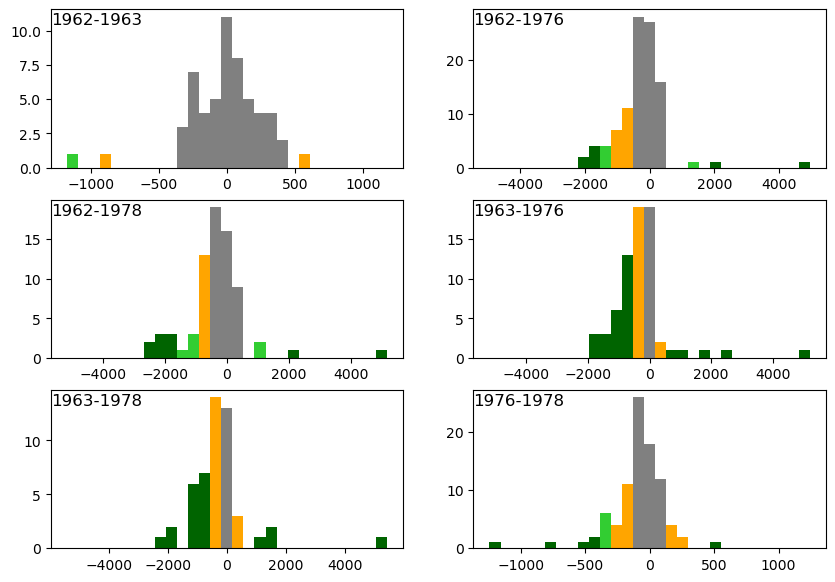

In [ ]:
fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(10, 7))

color_sigma = "orange"
color_2_sigma = "limegreen"
color_3_sigma = "darkgreen"
nbins = 30

years = (1962, 1963)
d = results_box.loc[results_box.years == years].mean_distance
N, bins, patches = axs[0, 0].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties_box.loc[uncertainties_box.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2  # shift bins to the center
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[0, 0].set_title(f"{years[0]}-{years[1]}", y=0.85, loc="left")
print(d.shape[0], d.mean(), d.std())
        
years = (1962, 1976)
d = results_box.loc[results_box.years == years].mean_distance
N, bins, patches = axs[0, 1].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties_box.loc[uncertainties_box.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[0, 1].set_title(f"{years[0]}-{years[1]}", y=0.85, loc="left")
print(d.shape[0], d.mean(), d.std())
        
years = (1962, 1978)
d = results_box.loc[results_box.years == years].mean_distance
N, bins, patches = axs[1, 0].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties_box.loc[uncertainties_box.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[1, 0].set_title(f"{years[0]}-{years[1]}", y=0.85, loc="left")
print(d.shape[0], d.mean(), d.std())
        
years = (1963, 1976)
d = results_box.loc[results_box.years == years].mean_distance
N, bins, patches = axs[1, 1].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties_box.loc[uncertainties_box.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[1, 1].set_title(f"{years[0]}-{years[1]}", y=0.85, loc="left")
print(d.shape[0], d.mean(), d.std())
        
years = (1963, 1978)
d = results_box.loc[results_box.years == years].mean_distance
N, bins, patches = axs[2, 0].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties_box.loc[uncertainties_box.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[2, 0].set_title(f"{years[0]}-{years[1]}", y=0.85, loc="left")
print(d.shape[0], d.mean(), d.std())
        
years = (1976, 1978)
d = results_box.loc[results_box.years == years].mean_distance
N, bins, patches = axs[2, 1].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties_box.loc[uncertainties_box.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[2, 1].set_title(f"{years[0]}-{years[1]}", y=0.85, loc="left")
print(d.shape[0], d.mean(), d.std())
fig.savefig("images/results_distances_distributions_box.png", bbox_inches="tight")

56 -12.116049936165911 285.97277742518907
102 -282.9527534926665 816.0470398063975
73 -333.8110257425083 1025.903472774374
70 -294.1881361217037 965.58531808538
50 -266.9288281799495 1091.8673067750017
89 -87.37393087527789 216.99131025661916


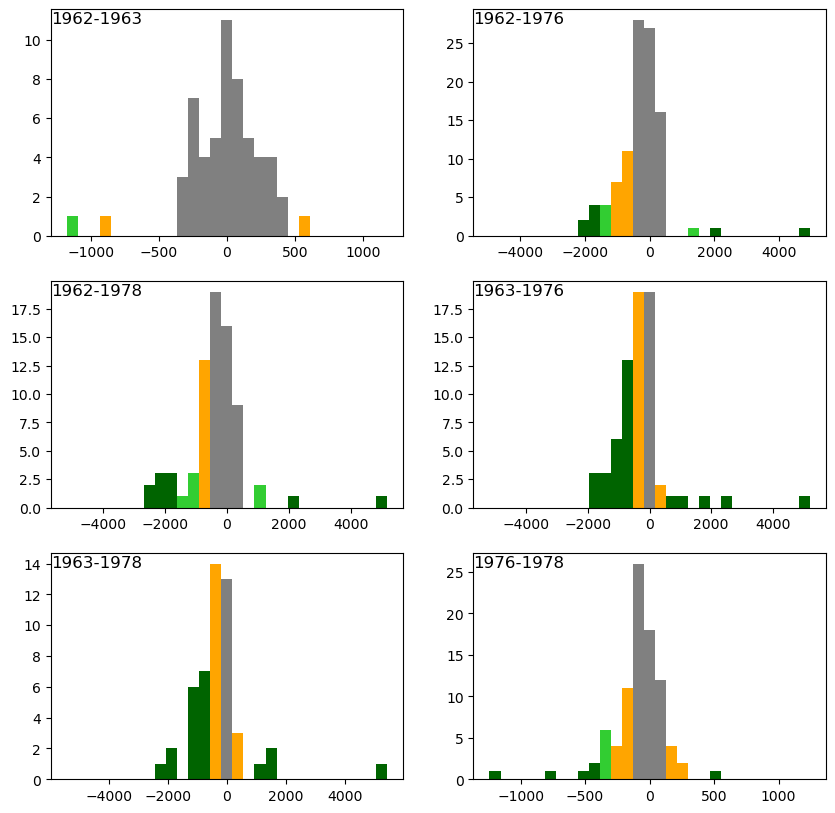

In [ ]:
fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(10, 10))

color_sigma = "orange"
color_2_sigma = "limegreen"
color_3_sigma = "darkgreen"
nbins = 30

years = (1962, 1963)
d = results_box.loc[results_box.years == years].mean_distance
N, bins, patches = axs[0, 0].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties_box.loc[uncertainties_box.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2  # shift bins to the center
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[0, 0].set_title(f"{years[0]}-{years[1]}", y=0.9, loc="left")
print(d.shape[0], d.mean(), d.std())
        
years = (1962, 1976)
d = results_box.loc[results_box.years == years].mean_distance
N, bins, patches = axs[0, 1].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties_box.loc[uncertainties_box.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[0, 1].set_title(f"{years[0]}-{years[1]}", y=0.9, loc="left")
print(d.shape[0], d.mean(), d.std())
        
years = (1962, 1978)
d = results_box.loc[results_box.years == years].mean_distance
N, bins, patches = axs[1, 0].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties_box.loc[uncertainties_box.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[1, 0].set_title(f"{years[0]}-{years[1]}", y=0.9, loc="left")
print(d.shape[0], d.mean(), d.std())
        
years = (1963, 1976)
d = results_box.loc[results_box.years == years].mean_distance
N, bins, patches = axs[1, 1].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties_box.loc[uncertainties_box.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[1, 1].set_title(f"{years[0]}-{years[1]}", y=0.9, loc="left")
print(d.shape[0], d.mean(), d.std())
        
years = (1963, 1978)
d = results_box.loc[results_box.years == years].mean_distance
N, bins, patches = axs[2, 0].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties_box.loc[uncertainties_box.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[2, 0].set_title(f"{years[0]}-{years[1]}", y=0.9, loc="left")
print(d.shape[0], d.mean(), d.std())
        
years = (1976, 1978)
d = results_box.loc[results_box.years == years].mean_distance
N, bins, patches = axs[2, 1].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties_box.loc[uncertainties_box.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[2, 1].set_title(f"{years[0]}-{years[1]}", y=0.9, loc="left")
print(d.shape[0], d.mean(), d.std())
fig.savefig("images/results_distances_distributions_box_big.png", bbox_inches="tight")

In [ ]:
# list of surges and retreats

surges_box = pd.DataFrame(
    [],
    columns=["front_id", "years", "mean_distance", "uncertainty"]
)

retreats_box = pd.DataFrame(
    [],
    columns=["front_id", "years", "mean_distance", "uncertainty"]
)

for years in [(1962, 1963), (1962, 1976), (1962, 1978), (1963, 1976), (1963, 1978), (1976, 1978)]:
    # print("years :", years)
    sigma = uncertainties_box.loc[uncertainties_box.years == years]["sigma_dist"].values[0]
    res = results_box.where(results_box.loc[results_box.years == years, "mean_distance"].apply(lambda x: np.abs(x) >= 2 * sigma)).dropna().loc[:, ["front_id", "years", "mean_distance", "uncertainty"]]
    # print(res)
    surges_1 = res.where(res.mean_distance.apply(lambda x: x >= 0)).dropna()
    retreats_1 = res.where(res.mean_distance.apply(lambda x: x < 0)).dropna()
    if not surges_1.empty:
        surges_box = pd.concat([surges_box, surges_1])
    if not retreats_1.empty:
        retreats_box = pd.concat([retreats_box, retreats_1])
        
surges_box

C:\Users\loris\AppData\Local\Temp\ipykernel_21676\3083962847.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  retreats_box = pd.concat([retreats_box, retreats_1])
C:\Users\loris\AppData\Local\Temp\ipykernel_21676\3083962847.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  surges_box = pd.concat([surges_box, surges_1])


,front_id,years,mean_distance,uncertainty
113,56,"(1962, 1976)",1281.064771,1021.819945
254,122,"(1962, 1976)",4936.214159,1021.819945
307,121,"(1962, 1976)",2153.329321,1021.819945
114,56,"(1962, 1978)",1118.781515,1022.952589
255,122,"(1962, 1978)",5174.801442,1022.952589
308,121,"(1962, 1978)",2279.420071,1022.952589
115,56,"(1963, 1976)",1159.852106,468.277695
194,91,"(1963, 1976)",775.398523,468.277695
256,122,"(1963, 1976)",5198.308320,468.277695
398,92,"(1963, 1976)",1823.102178,468.277695


In [ ]:
retreats_box

,front_id,years,mean_distance,uncertainty
419,105,"(1962, 1963)",-1175.502816,1091.421092
40,37,"(1962, 1976)",-1401.692189,1021.819945
101,54,"(1962, 1976)",-1542.028761,1021.819945
223,161,"(1962, 1976)",-1023.359882,1021.819945
287,42,"(1962, 1976)",-1180.570938,1021.819945
...,...,...,...,...
391,73,"(1976, 1978)",-386.318624,272.976189
394,74,"(1976, 1978)",-381.492736,272.976189
400,92,"(1976, 1978)",-383.159906,272.976189
403,93,"(1976, 1978)",-805.205309,272.976189


In [ ]:
# list of all fronts that either surged or retreated with >95% accuracy
len(surges_box.front_id.unique()), surges_box.front_id.unique(), len(retreats_box.front_id.unique()), retreats_box.front_id.unique()

(8,
 array([56, 122, 121, 91, 92, 93, 120, 165], dtype=object),
 48,
 array([105, 37, 54, 161, 42, 109, 62, 76, 73, 74, 75, 95, 106, 154, 144,
        4, 28, 38, 41, 50, 51, 52, 53, 58, 180, 111, 141, 138, 139, 140,
        178, 142, 160, 2, 96, 97, 98, 33, 46, 49, 116, 124, 34, 43, 60, 92,
        93, 89], dtype=object))

## Comparison manual / box method

In [ ]:
for i in results_box.index.values:
    front_id, year1, year2 = results_box.loc[i][["front_id", "year_1", "year_2"]]
    for j in results.index.values:
        front_id_2, year1_2, year2_2 = results_box.loc[j][["front_id", "year_1", "year_2"]]
        if (front_id == front_id_2) and (year1 == year1_2) and (year2 == year2_2):
            results_box.loc[i, "mean_distance_2"] = results.loc[j, "mean_distance"]
            results_box.loc[i, "uncertainty_2"] = results.loc[j, "uncertainty"]
            
results_box

,front_id,year_1,year_2,years,distance,mean_distance,uncertainty,mean_distance_2,uncertainty_2
0,3,1963,1976,"(1963, 1976)","[-341.26830933591924, -463.03829475751604]",-402.153302,468.277695,-241.275979,1091.421092
1,4,1963,1976,"(1963, 1976)","[-501.3441551864909, -545.3417011649898, -367....",-776.636692,468.277695,-924.789543,1021.819945
2,25,1962,1963,"(1962, 1963)","[104.29363221683396, 260.1996766181235]",182.246654,1091.421092,-664.223629,468.277695
3,25,1962,1976,"(1962, 1976)","[251.13957302078396, 269.4042203817791, 81.303...",278.568870,1021.819945,-39.310605,1091.421092
4,25,1963,1976,"(1963, 1976)","[146.84594080395, 165.11058816494514, -22.9898...",96.322216,468.277695,148.672829,1021.819945
...,...,...,...,...,...,...,...,...,...
435,65,1976,1978,"(1976, 1978)",[-114.31890299647765],-114.318903,272.976189,-153.444729,272.976189
436,66,1976,1978,"(1976, 1978)",[-85.73270102390168],-85.732701,272.976189,-72.567047,272.976189
437,72,1976,1978,"(1976, 1978)",[-36.90731420880558],-36.907314,272.976189,-33.726691,272.976189
438,79,1976,1978,"(1976, 1978)",[-87.25323145609863],-87.253231,272.976189,-75.400310,272.976189


In [ ]:
results_cross = results_box.loc[:, ["front_id", "year_1", "year_2", "years", "mean_distance", "mean_distance_2", "uncertainty", "uncertainty_2"]]
results_cross.columns = ["front_id", "year_1", "year_2", "years", "mean_distance_box", "mean_distance_manual", "uncertainty_box", "uncertainty_manual"]
results_cross.dropna(inplace=True)
results_cross

,front_id,year_1,year_2,years,mean_distance_box,mean_distance_manual,uncertainty_box,uncertainty_manual
0,3,1963,1976,"(1963, 1976)",-402.153302,-241.275979,468.277695,1091.421092
1,4,1963,1976,"(1963, 1976)",-776.636692,-924.789543,468.277695,1021.819945
2,25,1962,1963,"(1962, 1963)",182.246654,-664.223629,1091.421092,468.277695
3,25,1962,1976,"(1962, 1976)",278.568870,-39.310605,1021.819945,1091.421092
4,25,1963,1976,"(1963, 1976)",96.322216,148.672829,468.277695,1021.819945
...,...,...,...,...,...,...,...,...
434,82,1976,1978,"(1976, 1978)",-136.123419,-91.974519,272.976189,272.976189
435,65,1976,1978,"(1976, 1978)",-114.318903,-153.444729,272.976189,272.976189
436,66,1976,1978,"(1976, 1978)",-85.732701,-72.567047,272.976189,272.976189
437,72,1976,1978,"(1976, 1978)",-36.907314,-33.726691,272.976189,272.976189


In [ ]:
scipy.stats.linregress(
    results_cross.mean_distance_box,
    results_cross.mean_distance_manual
)

LinregressResult(slope=0.3658408618648422, intercept=-42.74411748948775, rvalue=0.5431427134089073, pvalue=4.7096284220368577e-35, stderr=0.02705396100380733, intercept_stderr=22.40278651704487)

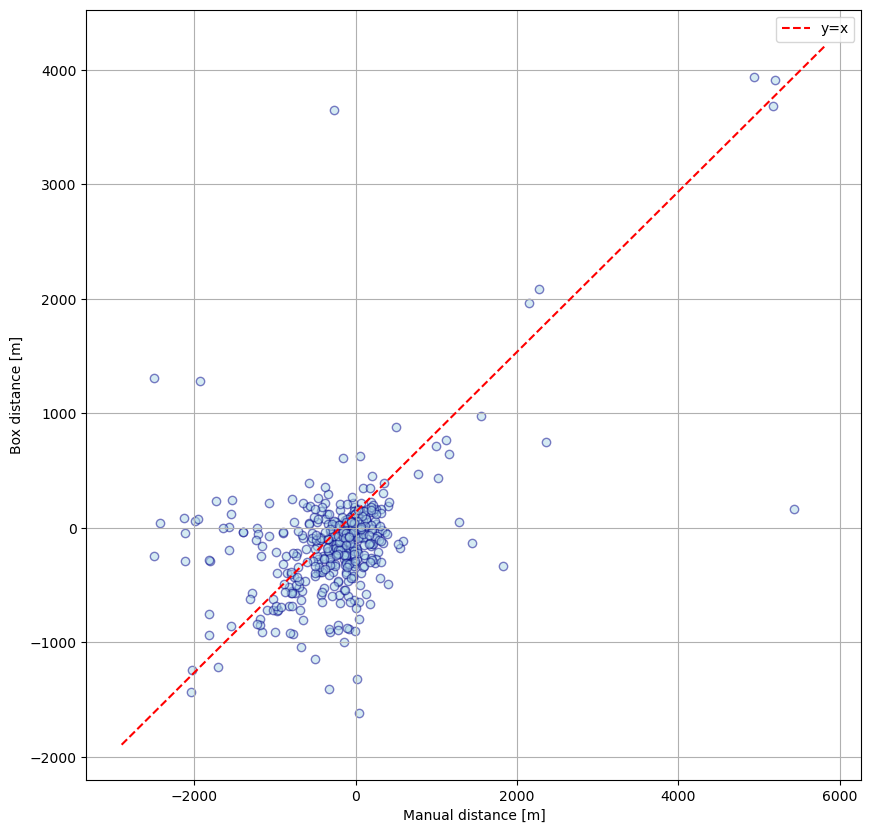

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(results_cross.mean_distance_box, results_cross.mean_distance_manual, color="lightblue", edgecolor="darkblue", alpha=0.5)
ax.plot(ax.get_xlim(), ax.get_ylim(), color="red", linestyle="--", label="y=x")
ax.grid()
ax.legend()
ax.set_xlabel("Manual distance [m]")
ax.set_ylabel("Box distance [m]")
fig.savefig("images/results_cross_distances.png", bbox_inches="tight")

# NEW

## Box distance

In [4]:
boxes = gpd.read_file(posixpath.join(data_root, "boxes/boxes.shp")).to_crs(epsg=25833)
boxes.head()

,front_id,front_dir,RGI60ID,RGI70ID,geometry
0,1,NE,RGI60-07.01494,RGI2000-v7.0-G-07-00054,"POLYGON ((448958.093 8831407.133, 451132.965 8..."
1,2,NE,RGI60-07.00791,RGI2000-v7.0-G-07-01223,"POLYGON ((448556.464 8831393.624, 447609.196 8..."
2,3,E,RGI60-07.00777,RGI2000-v7.0-G-07-01225,"POLYGON ((446223.949 8833013.329, 449012.234 8..."
3,4,SE,RGI60-07.00775,RGI2000-v7.0-G-07-01229,"POLYGON ((445849.929 8838239.577, 448611.174 8..."
4,5,NE,RGI60-07.00794,RGI2000-v7.0-G-07-01268,"POLYGON ((444478.132 8842149.605, 443352.455 8..."


In [5]:
uncertainties_box = pd.read_csv("./uncertainties_box.csv", dtype={"year_1": int, "year_2": int})
uncertainties_box.loc[:, "years"] = uncertainties_box.loc[:, ["year_1", "year_2"]].apply(lambda x: (x.iloc[0], x.iloc[1]), axis=1)
uncertainties_box

,year_1,year_2,sigma_dist,2_sigma_dist,3_sigma_dist,years
0,1936,1936,29.698485,59.396970,89.095454,"(1936, 1936)"
1,1936,1962,500.440806,1000.881611,1501.322417,"(1936, 1962)"
2,1936,1963,216.023147,432.046294,648.069441,"(1936, 1963)"
3,1936,1976,98.270036,196.540072,294.810108,"(1936, 1976)"
4,1936,1978,100.224747,200.449495,300.674242,"(1936, 1978)"
5,1962,1962,707.106781,1414.213562,2121.320344,"(1962, 1962)"
6,1962,1963,544.265560,1088.531120,1632.796681,"(1962, 1963)"
7,1962,1976,509.132596,1018.265191,1527.397787,"(1962, 1976)"
8,1962,1978,509.513493,1019.026987,1528.540480,"(1962, 1978)"
9,1963,1963,304.055916,608.111832,912.167748,"(1963, 1963)"


#### General trend

In [6]:
uncertainties_box_single = pd.read_csv("./uncertainties_box_single.csv", dtype={"year": int, "sigma": int})
uncertainties_box_single

,year,sigma
0,1936,21
1,1962,500
2,1963,215
3,1976,96
4,1978,98


In [7]:
def get_year(timestamp):
    return timestamp.year

positions_box = pd.DataFrame(
    [],
    columns = ["front_id", "year", "total_count", "skip_count", "distances", "mean", "std"]
)

fronts_list = np.sort(all_fronts.front_id.unique())
 
print("Distances calculations ...")
for front_id in fronts_list:
    front_data = all_fronts.loc[all_fronts.front_id == front_id]
    years = np.sort(front_data['timestamp'].apply(get_year).unique())

    if not boxes.loc[boxes.front_id == front_id].empty:
        box = boxes.loc[boxes.front_id == front_id].geometry.values[0]

    for year in years:
        front_data_year = front_data.loc[front_data['timestamp'].apply(get_year) == year]
        total_count = len(front_data_year)
        skip_count = 0
        dists = []
        for i in range(len(front_data_year)):
            front = front_data_year.iloc[i].geometry
            dirs = front_data_year.front_dir
            if len(dirs.unique()) == 1:
                dir = dirs.unique()[0]
                try:
                    dist, e = distances.box_measure(front, dir, box)
                    if dist is not None:
                        dists.append(dist)
                    elif e != 0:
                        skip_count += 1
                except Exception as ex:
                    print(f"front {front_id} : ")
                    print(ex)
                    skip_count += 1
            else:
                skip_count += 1
        dists = np.array(dists)
                
        results_i = pd.DataFrame(
            [],
            columns = ["front_id", "year", "total_count", "skip_count", "distances", "mean", "std"]
        )
        results_i.loc[len(results_i)] = [front_id, year, total_count, skip_count, dists, None, None]
        
        if dists.shape[0] > 0:
            results_i.loc[len(results_i) - 1, "mean"] = np.mean(dists)
        if dists.shape[0] > 1:
            results_i.loc[len(results_i) - 1, "std"] = np.std(dists)

        positions_box = pd.concat([positions_box, results_i], ignore_index=True)
        
positions_box.loc[:, "uncertainty"] = positions_box.loc[:, ["year"]].apply(lambda x: uncertainties_box_single.loc[uncertainties_box_single.year == x.iloc[0], "sigma"].values[0], axis=1)
positions_box.dropna(axis=0, subset="mean", inplace=True)
positions_box

Distances calculations ...
front 116 : 
operands could not be broadcast together with shapes (3,2) (2,2) 
front 182 : 
Unknown direction: None
front 183 : 
Unknown direction: None
front 184 : 
Unknown direction: None
front 185 : 
Unknown direction: None


,front_id,year,total_count,skip_count,distances,mean,std,uncertainty
0,1,1936,1,0,[3211.846560613241],3211.846561,None,21
1,1,1962,3,0,"[2938.9338563623846, 3688.2350543288517, 3405....",3344.199067,308.949656,500
2,1,1963,2,0,"[2873.0605978626286, 3116.2386074220553]",2994.649603,121.589005,215
3,1,1976,5,0,"[2604.52164719872, 2608.4023003573, 2512.55142...",2571.744161,35.304391,96
4,1,1978,1,0,[2620.9760204313975],2620.97602,None,98
...,...,...,...,...,...,...,...,...
652,180,1962,2,0,"[2066.0960438439097, 2313.923431750415]",2190.009738,123.913694,500
653,180,1963,2,0,"[1868.0384665298482, 2072.911729351007]",1970.475098,102.436631,215
654,180,1976,1,0,[1343.696234493521],1343.696234,None,96
655,181,1936,1,0,[1499.936425338489],1499.936425,None,21


In [8]:
for front_id in fronts_list:
    front_data = positions_box.loc[positions_box.front_id == front_id]
    if not front_data.loc[front_data.year == 1936].empty:
        front_data["mean_corrected"] = front_data["mean"] - front_data.loc[front_data.year == 1936]["mean"].values[0]
        positions_box.loc[positions_box.front_id == front_id, "mean_corrected"] = front_data["mean_corrected"]

positions_box

C:\Users\loris\AppData\Local\Temp\ipykernel_7404\791252403.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  front_data["mean_corrected"] = front_data["mean"] - front_data.loc[front_data.year == 1936]["mean"].values[0]
C:\Users\loris\AppData\Local\Temp\ipykernel_7404\791252403.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  front_data["mean_corrected"] = front_data["mean"] - front_data.loc[front_data.year == 1936]["mean"].values[0]
C:\Users\loris\AppData\Local\Temp\ipykernel_7404\791252403.py:4: Setti

,front_id,year,total_count,skip_count,distances,mean,std,uncertainty,mean_corrected
0,1,1936,1,0,[3211.846560613241],3211.846561,None,21,0.0
1,1,1962,3,0,"[2938.9338563623846, 3688.2350543288517, 3405....",3344.199067,308.949656,500,132.352507
2,1,1963,2,0,"[2873.0605978626286, 3116.2386074220553]",2994.649603,121.589005,215,-217.196958
3,1,1976,5,0,"[2604.52164719872, 2608.4023003573, 2512.55142...",2571.744161,35.304391,96,-640.102399
4,1,1978,1,0,[2620.9760204313975],2620.97602,None,98,-590.87054
...,...,...,...,...,...,...,...,...,...
652,180,1962,2,0,"[2066.0960438439097, 2313.923431750415]",2190.009738,123.913694,500,-1703.263221
653,180,1963,2,0,"[1868.0384665298482, 2072.911729351007]",1970.475098,102.436631,215,-1922.797861
654,180,1976,1,0,[1343.696234493521],1343.696234,None,96,-2549.576724
655,181,1936,1,0,[1499.936425338489],1499.936425,None,21,0.0


In [9]:
mean_glaciers = positions_box.groupby("year")["mean_corrected"].mean()
mean_glaciers

year
1936            0.0
1962    -952.598377
1963   -1070.717775
1976   -1024.552779
1978   -1271.904879
Name: mean_corrected, dtype: object

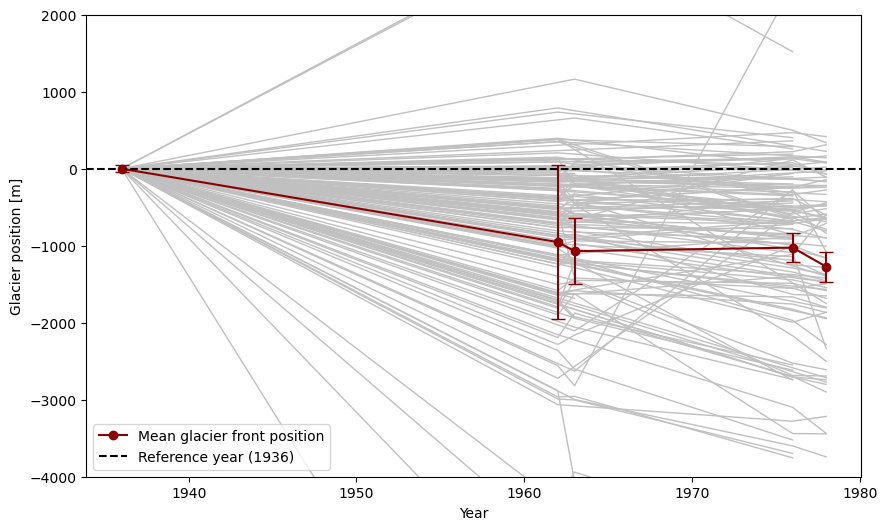

In [10]:
fig, ax = plt.subplots(figsize=[10, 6])


for front_id in fronts_list:
    ax.plot(positions_box.loc[positions_box.front_id == front_id].year, positions_box.loc[positions_box.front_id == front_id].mean_corrected, marker=" ", linestyle="-", markersize=3, color="silver", linewidth=1, alpha=1)
    
x = mean_glaciers.index
y = mean_glaciers.values
err = 2 * uncertainties_box_single.sigma.values
ax.plot(x, y, marker="o", linestyle="-", color="darkred", linewidth=1.5, label="Mean glacier front position")
ax.errorbar(x, y, yerr=err, fmt='o', color='darkred', markersize=3, capsize=5)
ax.axhline(y=0, color="k", linestyle="--", linewidth=1.5, label="Reference year (1936)")
ax.set_ylim([-4000, 2000])
ax.set_xlabel("Year")
ax.set_ylabel("Glacier position [m]")
ax.legend()
fig.savefig("images/mean_glacier_front_position_box.png", bbox_inches="tight")

#### Identification of specific events

In [8]:
def get_year(timestamp):
    return timestamp.year

results_box = pd.DataFrame(
    [],
    columns = ["front_id", "year_1", "year_2", "distance"]
)
total_count = 0
skip_count = 0
years = [1936, 1962, 1963, 1976, 1978]

for front in all_fronts.front_id.unique():
    # compare observations from any year to fronts from any other year, for a specific front.
    for i_year in range(len(years) - 1):
        year = years[i_year]
        fronts = all_fronts.loc[all_fronts.front_id == front].loc[all_fronts.timestamp.apply(get_year) == year]
        for i_other_year in range(i_year + 1, len(years)):
            other_year = years[i_other_year]
            other_fronts = all_fronts.loc[all_fronts.front_id == front].loc[all_fronts.timestamp.apply(get_year) == other_year]
            
            dists = []
            # compare all the observations between them
            for k in range(len(fronts.geometry)):
                for l in range(len(other_fronts.geometry)):
                    front1 = fronts.geometry.iloc[k]
                    front2 = other_fronts.geometry.iloc[l]
                    dir_1 = fronts.front_dir.iloc[k]
                    dir_2 = other_fronts.front_dir.iloc[l]
                    try:
                        if not boxes.loc[boxes.front_id == fronts.front_id.iloc[k]].empty:
                            box = boxes.loc[boxes.front_id == fronts.front_id.iloc[k]].geometry.values[0]
                            dist, e = distances.box_distance(front1, front2, box, dir_1, dir_2)
                            if dist is not None:
                                dists.append(dist)
                            elif e == 1:
                                skip_count += 1
                        else:
                            skip_count += 1
                    except AssertionError:
                        skip_count += 1
                    total_count += 1
            
            if not dists == []:
                # horrible hack to load an array as a value in a DataFrame
                results_i = pd.DataFrame(
                    [[front, year, other_year, np.array(dists)]],
                    columns=["front_id", "year_1", "year_2", "distance"]
                )      
            else: # load None instead of a list of distances
                results_i = pd.DataFrame(
                    [[front, year, other_year, None]],
                    columns=["front_id", "year_1", "year_2", "distance"]
                )
            results_box = pd.concat([results_box, results_i])
            
print(f"Skipped {skip_count} comparisons out of {total_count}.")
results_box.reset_index(drop=True, inplace=True)
results_box = results_box.dropna().reset_index(drop=True)


results_box.loc[:, "mean_distance"] = results_box.distance.apply(lambda x: np.array(x).mean())
results_box.loc[:, "uncertainty"] = results_box.loc[:, ["year_1", "year_2"]].apply(lambda x: uncertainties_box.loc[(uncertainties_box.year_1 == x.iloc[0]) & (uncertainties_box.year_2 == x.iloc[1]), "2_sigma_dist"].values[0], axis=1)

# not necessary but easier to control results : put the years in a single column. 
results_box.loc[:, "years"] = results_box.loc[:, ["year_1", "year_2"]].apply(lambda x: (x.iloc[0], x.iloc[1]), axis=1)
results_box = results_box[["front_id", "year_1", "year_2", "years", "distance", "mean_distance", "uncertainty"]]

results_box

Skipped 738 comparisons out of 2967.


,front_id,year_1,year_2,years,distance,mean_distance,uncertainty
0,77,1936,1962,"(1936, 1962)","[-1242.5244095968242, -1108.137981874091]",-1175.331196,998.883377
1,77,1936,1976,"(1936, 1976)",[-1374.9205411934863],-1374.920541,194.586742
2,77,1936,1978,"(1936, 1978)",[-1419.501964673488],-1419.501965,200.449495
3,77,1962,1976,"(1962, 1976)","[-132.3961315966622, -266.78255931939503]",-199.589345,1015.925194
4,77,1962,1978,"(1962, 1978)","[-176.9775550766638, -311.36398279939664]",-244.170769,1017.064403
...,...,...,...,...,...,...,...
834,165,1962,1976,"(1962, 1976)","[-367.6942015637037, -361.95752751003596, -161...",-414.344392,1015.925194
835,165,1962,1978,"(1962, 1978)","[-72.23986565169943, 133.93433507317275, -1978...",-121.758393,1017.064403
836,165,1976,1978,"(1976, 1978)","[295.45433591200424, 289.71766185833656]",292.585999,272.976189
837,168,1962,1978,"(1962, 1978)","[916.0482169934909, -288.39078112381566, -763....",-347.129713,1017.064403


100 -952.5983773546687 1404.1027076877451
76 -1070.7177751891475 1569.6441189956154
130 -1029.237584447583 1535.1813907437745
90 -1270.9321642901464 1691.402267567869
56 -12.116049936165913 285.97277742518907
103 -289.3528460581797 814.6306037446932
75 -353.6640235002554 1019.6691131263352
70 -294.18813612170356 965.5853180853801
50 -266.9288281799495 1091.867306775002
89 -87.37393087527789 216.9913102566192


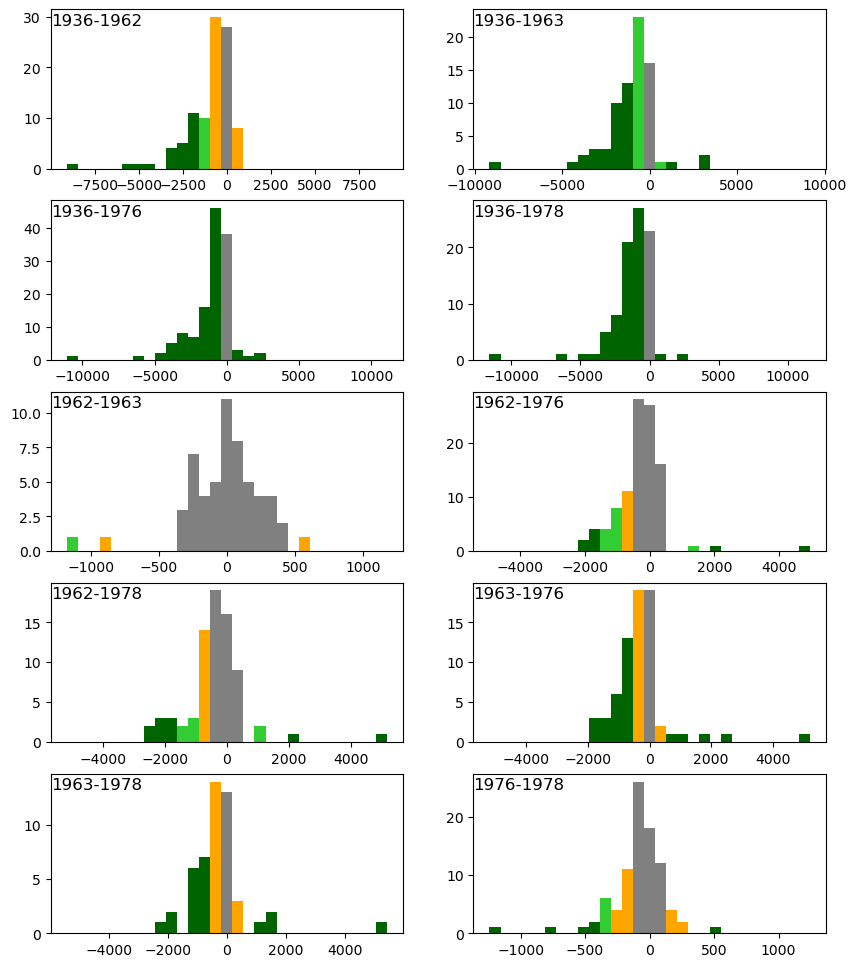

In [9]:
fig, axs = plt.subplots(ncols=2, nrows=5, figsize=(10, 12))

color_sigma = "orange"
color_2_sigma = "limegreen"
color_3_sigma = "darkgreen"
nbins = 30

years = (1936, 1962)
d = results_box.loc[results_box.years == years].mean_distance
N, bins, patches = axs[0, 0].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties_box.loc[uncertainties_box.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2  # shift bins to the center
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[0, 0].set_title(f"{years[0]}-{years[1]}", y=0.85, loc="left")
print(d.shape[0], d.mean(), d.std())

years = (1936, 1963)
d = results_box.loc[results_box.years == years].mean_distance
N, bins, patches = axs[0, 1].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties_box.loc[uncertainties_box.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2  # shift bins to the center
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[0, 1].set_title(f"{years[0]}-{years[1]}", y=0.85, loc="left")
print(d.shape[0], d.mean(), d.std())

years = (1936, 1976)
d = results_box.loc[results_box.years == years].mean_distance
N, bins, patches = axs[1, 0].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties_box.loc[uncertainties_box.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2  # shift bins to the center
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[1, 0].set_title(f"{years[0]}-{years[1]}", y=0.85, loc="left")
print(d.shape[0], d.mean(), d.std())

years = (1936, 1978)
d = results_box.loc[results_box.years == years].mean_distance
N, bins, patches = axs[1, 1].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties_box.loc[uncertainties_box.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2  # shift bins to the center
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[1, 1].set_title(f"{years[0]}-{years[1]}", y=0.85, loc="left")
print(d.shape[0], d.mean(), d.std())

years = (1962, 1963)
d = results_box.loc[results_box.years == years].mean_distance
N, bins, patches = axs[2, 0].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties_box.loc[uncertainties_box.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2  # shift bins to the center
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[2, 0].set_title(f"{years[0]}-{years[1]}", y=0.85, loc="left")
print(d.shape[0], d.mean(), d.std())
        
years = (1962, 1976)
d = results_box.loc[results_box.years == years].mean_distance
N, bins, patches = axs[2, 1].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties_box.loc[uncertainties_box.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[2, 1].set_title(f"{years[0]}-{years[1]}", y=0.85, loc="left")
print(d.shape[0], d.mean(), d.std())
        
years = (1962, 1978)
d = results_box.loc[results_box.years == years].mean_distance
N, bins, patches = axs[3, 0].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties_box.loc[uncertainties_box.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[3, 0].set_title(f"{years[0]}-{years[1]}", y=0.85, loc="left")
print(d.shape[0], d.mean(), d.std())
        
years = (1963, 1976)
d = results_box.loc[results_box.years == years].mean_distance
N, bins, patches = axs[3, 1].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties_box.loc[uncertainties_box.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[3, 1].set_title(f"{years[0]}-{years[1]}", y=0.85, loc="left")
print(d.shape[0], d.mean(), d.std())
        
years = (1963, 1978)
d = results_box.loc[results_box.years == years].mean_distance
N, bins, patches = axs[4, 0].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties_box.loc[uncertainties_box.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[4, 0].set_title(f"{years[0]}-{years[1]}", y=0.85, loc="left")
print(d.shape[0], d.mean(), d.std())
        
years = (1976, 1978)
d = results_box.loc[results_box.years == years].mean_distance
N, bins, patches = axs[4, 1].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties_box.loc[uncertainties_box.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[4, 1].set_title(f"{years[0]}-{years[1]}", y=0.85, loc="left")
print(d.shape[0], d.mean(), d.std())
fig.savefig("images/results_distances_distributions_box_with_NPI.png", bbox_inches="tight")

In [10]:
# list of surges and retreats

surges_box = pd.DataFrame(
    [],
    columns=["front_id", "years", "mean_distance", "uncertainty"]
)

retreats_box = pd.DataFrame(
    [],
    columns=["front_id", "years", "mean_distance", "uncertainty"]
)

for years in [(1936, 1962),
              (1936, 1963),
              (1936, 1976),
              (1936, 1978),
              (1962, 1963), 
              (1962, 1976), 
              (1962, 1978), 
              (1963, 1976), 
              (1963, 1978), 
              (1976, 1978)]:
    # print("years :", years)
    sigma = uncertainties_box.loc[uncertainties_box.years == years]["sigma_dist"].values[0]
    res = results_box.where(results_box.loc[results_box.years == years, "mean_distance"].apply(lambda x: np.abs(x) >= 2 * sigma)).dropna().loc[:, ["front_id", "years", "mean_distance", "uncertainty"]]
    # print(res)
    surges_1 = res.where(res.mean_distance.apply(lambda x: x >= 0)).dropna()
    retreats_1 = res.where(res.mean_distance.apply(lambda x: x < 0)).dropna()
    if not surges_1.empty:
        surges_box = pd.concat([surges_box, surges_1])
    if not retreats_1.empty:
        retreats_box = pd.concat([retreats_box, retreats_1])
        
surges_box

C:\Users\loris\AppData\Local\Temp\ipykernel_23148\1719078495.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  retreats_box = pd.concat([retreats_box, retreats_1])
C:\Users\loris\AppData\Local\Temp\ipykernel_23148\1719078495.py:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  surges_box = pd.concat([surges_box, surges_1])


,front_id,years,mean_distance,uncertainty
175,50,"(1936, 1963)",1163.262446,430.055810
362,3,"(1936, 1963)",658.621812,430.055810
476,139,"(1936, 1963)",3124.432226,430.055810
515,141,"(1936, 1963)",3089.557820,430.055810
160,172,"(1936, 1976)",403.216706,194.586742
176,50,"(1936, 1976)",500.015784,194.586742
260,173,"(1936, 1976)",286.875847,194.586742
363,3,"(1936, 1976)",256.468510,194.586742
409,125,"(1936, 1976)",469.071196,194.586742
477,139,"(1936, 1976)",2225.967410,194.586742


In [11]:
retreats_box

,front_id,years,mean_distance,uncertainty
0,77,"(1936, 1962)",-1175.331196,998.883377
52,69,"(1936, 1962)",-3064.133817,998.883377
58,67,"(1936, 1962)",-1120.141471,998.883377
67,68,"(1936, 1962)",-1644.002882,998.883377
91,81,"(1936, 1962)",-1013.061123,998.883377
...,...,...,...,...
218,53,"(1976, 1978)",-313.736313,272.976189
436,109,"(1976, 1978)",-502.040185,272.976189
577,43,"(1976, 1978)",-286.790089,272.976189
587,37,"(1976, 1978)",-332.779324,272.976189


In [12]:
# list of all fronts that either surged or retreated with >95% accuracy
len(surges_box.front_id.unique()), surges_box.front_id.unique(), len(retreats_box.front_id.unique()), retreats_box.front_id.unique()

(18,
 array([50, 3, 139, 141, 172, 173, 125, 157, 122, 175, 64, 56, 121, 120,
        93, 92, 91, 165], dtype=object),
 129,
 array([77, 69, 67, 68, 81, 100, 101, 96, 60, 61, 105, 180, 51, 39, 34, 54,
        31, 30, 109, 111, 113, 114, 140, 106, 122, 120, 57, 56, 42, 58,
        121, 138, 161, 103, 99, 93, 92, 52, 41, 53, 38, 137, 29, 27, 26,
        136, 112, 115, 178, 142, 43, 37, 28, 35, 46, 47, 48, 181, 91, 110,
        124, 150, 144, 153, 160, 66, 71, 72, 87, 80, 65, 89, 90, 40, 33,
        32, 18, 23, 21, 16, 14, 1, 4, 6, 5, 134, 126, 127, 8, 9, 12, 11, 2,
        133, 7, 10, 15, 17, 19, 20, 22, 24, 55, 78, 82, 88, 119, 143, 145,
        149, 146, 86, 49, 83, 154, 84, 116, 158, 62, 73, 74, 95, 75, 76,
        98, 97, 50, 139, 141], dtype=object))

## Centerline method

In [11]:
centerlines = gpd.read_file(posixpath.join(data_root, "centerlines/centerlines.shp")).to_crs(epsg=25833)
centerlines.head()

,front_id,front_dir,RGI60ID,RGI70ID,geometry
0,73,S,RGI60-07.00324,RGI2000-v7.0-G-07-01545,"LINESTRING (534321.434 8546768.732, 534362.547..."
1,68,SE,RGI60-07.00244,RGI2000-v7.0-G-07-01541,"LINESTRING (521713.665 8552295.499, 521056.825..."
2,61,NW,RGI60-07.00235,RGI2000-v7.0-G-07-00899,"LINESTRING (522358.058 8605537.509, 522635.212..."
3,96,SE,RGI60-07.00422,RGI2000-v7.0-G-07-00916,"LINESTRING (560900.741 8615217.504, 561141.212..."
4,1,NE,RGI60-07.01494,RGI2000-v7.0-G-07-00054,"LINESTRING (449615.704 8824196.706, 449565.438..."


In [12]:
uncertainties_cl = pd.read_csv("./uncertainties_cl.csv", dtype={"year_1": int, "year_2": int})
uncertainties_cl.loc[:, "years"] = uncertainties_cl.loc[:, ["year_1", "year_2"]].apply(lambda x: (x.iloc[0], x.iloc[1]), axis=1)
uncertainties_cl

,year_1,year_2,sigma_dist,2_sigma_dist,3_sigma_dist,years
0,1936,1936,29.698485,59.396970,89.095454,"(1936, 1936)"
1,1936,1962,211.047388,422.094776,633.142164,"(1936, 1962)"
2,1936,1963,115.918075,231.836149,347.754224,"(1936, 1963)"
3,1936,1976,87.555697,175.111393,262.667090,"(1936, 1976)"
4,1936,1978,55.154329,110.308658,165.462987,"(1936, 1978)"
5,1962,1962,296.984848,593.969696,890.954544,"(1962, 1962)"
6,1962,1963,238.947693,477.895386,716.843079,"(1962, 1963)"
7,1962,1976,226.550215,453.100430,679.650646,"(1962, 1976)"
8,1962,1978,216.104142,432.208283,648.312425,"(1962, 1978)"
9,1963,1963,161.220346,322.440692,483.661038,"(1963, 1963)"


#### General Trend

In [13]:
uncertainties_cl_single = pd.read_csv("./uncertainties_cl_single.csv", dtype={"year": int, "sigma": int})
uncertainties_cl_single

,year,sigma
0,1936,21
1,1962,210
2,1963,114
3,1976,85
4,1978,51


In [14]:
def get_year(timestamp):
    return timestamp.year

positions_cl = pd.DataFrame(
    [],
    columns = ["front_id", "year", "total_count", "skip_count", "distances", "mean", "std"]
)

fronts_list = np.sort(all_fronts.front_id.unique())
 
print("Distances calculations ...")
for front_id in fronts_list:
    front_data = all_fronts.loc[all_fronts.front_id == front_id]
    years = np.sort(front_data['timestamp'].apply(get_year).unique())

    if not centerlines.loc[centerlines.front_id == front_id].empty:
        cl = centerlines.loc[centerlines.front_id == front_id].geometry.values[0]

    for year in years:
        front_data_year = front_data.loc[front_data['timestamp'].apply(get_year) == year]
        total_count = len(front_data_year)
        skip_count = 0
        dists = []
        for i in range(len(front_data_year)):
            front = front_data_year.iloc[i].geometry
            dirs = front_data_year.front_dir
            if len(dirs.unique()) == 1:
                dir = dirs.unique()[0]
                try:
                    dist, e = distances.curvilinear_measure(front, dir, cl)
                    if dist is not None:
                        dists.append(dist)
                    elif e != 0:
                        skip_count += 1
                except Exception as ex:
                    print(f"front {front_id} : ")
                    print(ex)
                    skip_count += 1
            else:
                skip_count += 1
        dists = np.array(dists)
                
        results_i = pd.DataFrame(
            [],
            columns = ["front_id", "year", "total_count", "skip_count", "distances", "mean", "std"]
        )
        results_i.loc[len(results_i)] = [front_id, year, total_count, skip_count, dists, None, None]
        
        if dists.shape[0] > 0:
            results_i.loc[len(results_i) - 1, "mean"] = np.mean(dists)
        if dists.shape[0] > 1:
            results_i.loc[len(results_i) - 1, "std"] = np.std(dists)

        positions_cl = pd.concat([positions_cl, results_i], ignore_index=True)

positions_cl.loc[:, "uncertainty"] = positions_cl.loc[:, ["year"]].apply(lambda x: uncertainties_cl_single.loc[uncertainties_cl_single.year == x.iloc[0], "sigma"].values[0], axis=1)
positions_cl.dropna(axis=0, subset="mean", inplace=True)
positions_cl

Distances calculations ...
front 182 : 
Unknown direction: None
front 183 : 
Unknown direction: None
front 184 : 
Unknown direction: None
front 185 : 
Unknown direction: None


,front_id,year,total_count,skip_count,distances,mean,std,uncertainty
0,1,1936,1,0,[4702.487552088412],4702.487552,None,21
1,1,1962,3,0,"[4476.70408054527, 4959.295008350293, 4812.926...",4749.64199,202.035037,210
2,1,1963,2,0,"[4474.0290142095355, 4708.0794293901745]",4591.054222,117.025208,114
3,1,1976,5,0,"[4430.704041383467, 4472.198621540529, 4434.96...",4446.090012,19.517703,85
4,1,1978,1,0,[4422.526687613699],4422.526688,None,51
...,...,...,...,...,...,...,...,...
652,180,1962,2,0,"[4139.702150733747, 4049.348900934944]",4094.525526,45.176625,210
653,180,1963,2,0,"[3871.6341081314936, 4025.6953921964546]",3948.66475,77.030642,114
654,180,1976,1,0,[3581.463570814432],3581.463571,None,85
655,181,1936,1,0,[1292.193796383875],1292.193796,None,21


In [15]:
for front_id in fronts_list:
    front_data = positions_cl.loc[positions_cl.front_id == front_id]
    if not front_data.loc[front_data.year == 1936].empty:
        front_data["mean_corrected"] = front_data["mean"] - front_data.loc[front_data.year == 1936]["mean"].values[0]
        positions_cl.loc[positions_cl.front_id == front_id, "mean_corrected"] = front_data["mean_corrected"]

positions_cl

C:\Users\loris\AppData\Local\Temp\ipykernel_7404\2222153882.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  front_data["mean_corrected"] = front_data["mean"] - front_data.loc[front_data.year == 1936]["mean"].values[0]
C:\Users\loris\AppData\Local\Temp\ipykernel_7404\2222153882.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  front_data["mean_corrected"] = front_data["mean"] - front_data.loc[front_data.year == 1936]["mean"].values[0]
C:\Users\loris\AppData\Local\Temp\ipykernel_7404\2222153882.py:4: Se

,front_id,year,total_count,skip_count,distances,mean,std,uncertainty,mean_corrected
0,1,1936,1,0,[4702.487552088412],4702.487552,None,21,0.0
1,1,1962,3,0,"[4476.70408054527, 4959.295008350293, 4812.926...",4749.64199,202.035037,210,47.154438
2,1,1963,2,0,"[4474.0290142095355, 4708.0794293901745]",4591.054222,117.025208,114,-111.43333
3,1,1976,5,0,"[4430.704041383467, 4472.198621540529, 4434.96...",4446.090012,19.517703,85,-256.39754
4,1,1978,1,0,[4422.526687613699],4422.526688,None,51,-279.960864
...,...,...,...,...,...,...,...,...,...
652,180,1962,2,0,"[4139.702150733747, 4049.348900934944]",4094.525526,45.176625,210,-886.89838
653,180,1963,2,0,"[3871.6341081314936, 4025.6953921964546]",3948.66475,77.030642,114,-1032.759156
654,180,1976,1,0,[3581.463570814432],3581.463571,None,85,-1399.960335
655,181,1936,1,0,[1292.193796383875],1292.193796,None,21,0.0


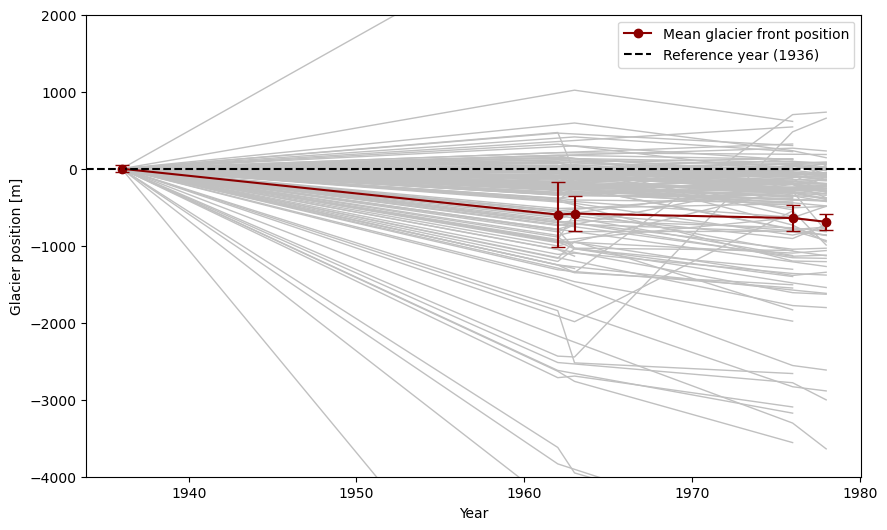

In [16]:
mean_glaciers = positions_cl.groupby("year")["mean_corrected"].mean()


fig, ax = plt.subplots(figsize=[10, 6])

for front_id in fronts_list:
    ax.plot(positions_cl.loc[positions_cl.front_id == front_id].year, positions_cl.loc[positions_cl.front_id == front_id].mean_corrected, marker=" ", linestyle="-", markersize=3, color="silver", linewidth=1, alpha=1)

x = mean_glaciers.index
y = mean_glaciers.values
err = 2 * uncertainties_cl_single.sigma.values
ax.plot(x, y, marker="o", linestyle="-", color="darkred", linewidth=1.5, label="Mean glacier front position")
ax.errorbar(x, y, yerr=err, fmt='o', color='darkred', markersize=3, capsize=5)
ax.axhline(y=0, color="k", linestyle="--", linewidth=1.5, label="Reference year (1936)")
ax.set_ylim([-4000, 2000])
ax.set_xlabel("Year")
ax.set_ylabel("Glacier position [m]")
ax.legend()
fig.savefig("images/mean_glacier_front_position_cl.png", bbox_inches="tight")

#### Identification of specific events

In [31]:
def get_year(timestamp):
    return timestamp.year

results_cl = pd.DataFrame(
    [],
    columns = ["front_id", "year_1", "year_2", "distance"]
)
total_count = 0
skip_count = 0
years = [1936, 1962, 1963, 1976, 1978]

for front in all_fronts.front_id.unique():
    # compare observations from any year to fronts from any other year, for a specific front.
    for i_year in range(len(years) - 1):
        year = years[i_year]
        fronts = all_fronts.loc[all_fronts.front_id == front].loc[all_fronts.timestamp.apply(get_year) == year]
        for i_other_year in range(i_year + 1, len(years)):
            other_year = years[i_other_year]
            other_fronts = all_fronts.loc[all_fronts.front_id == front].loc[all_fronts.timestamp.apply(get_year) == other_year]
            
            dists = []
            # compare all the observations between them
            for k in range(len(fronts.geometry)):
                for l in range(len(other_fronts.geometry)):
                    front1 = fronts.geometry.iloc[k]
                    front2 = other_fronts.geometry.iloc[l]
                    dir_1 = fronts.front_dir.iloc[k]
                    dir_2 = other_fronts.front_dir.iloc[l]
                    try:
                        if not centerlines.loc[centerlines.front_id == fronts.front_id.iloc[k]].empty:
                            cl = centerlines.loc[centerlines.front_id == fronts.front_id.iloc[k]].geometry.values[0]
                            dist, e = distances.curvilinear_distance(front1, front2, cl, dir_1, dir_2)
                            if dist is not None:
                                dists.append(dist)
                            elif e == 1:
                                skip_count += 1
                        else:
                            skip_count += 1
                    except AssertionError:
                        skip_count += 1
                    total_count += 1
            
            if not dists == []:
                # horrible hack to load an array as a value in a DataFrame
                results_i = pd.DataFrame(
                    [[front, year, other_year, np.array(dists)]],
                    columns=["front_id", "year_1", "year_2", "distance"]
                )      
            else: # load None instead of a list of distances
                results_i = pd.DataFrame(
                    [[front, year, other_year, None]],
                    columns=["front_id", "year_1", "year_2", "distance"]
                )
            results_cl = pd.concat([results_cl, results_i])
            
print(f"Skipped {skip_count} comparisons out of {total_count}.")
results_cl.reset_index(drop=True, inplace=True)
results_cl = results_cl.dropna().reset_index(drop=True)


results_cl.loc[:, "mean_distance"] = results_cl.distance.apply(lambda x: np.array(x).mean())
results_cl.loc[:, "uncertainty"] = results_cl.loc[:, ["year_1", "year_2"]].apply(lambda x: uncertainties_cl.loc[(uncertainties_cl.year_1 == x.iloc[0]) & (uncertainties_cl.year_2 == x.iloc[1]), "2_sigma_dist"].values[0], axis=1)

# not necessary but easier to control results : put the years in a single column. 
results_cl.loc[:, "years"] = results_cl.loc[:, ["year_1", "year_2"]].apply(lambda x: (x.iloc[0], x.iloc[1]), axis=1)
results_cl = results_cl[["front_id", "year_1", "year_2", "years", "distance", "mean_distance", "uncertainty"]]

results_cl

Skipped 265 comparisons out of 2967.


,front_id,year_1,year_2,years,distance,mean_distance,uncertainty
0,161,1936,1962,"(1936, 1962)","[2893.8148632743887, 3228.3994517792726, 3558....",3183.115243,422.094776
1,161,1936,1963,"(1936, 1963)","[2755.7311611977148, 2409.416482499926]",2582.573822,229.869528
2,161,1936,1976,"(1936, 1976)","[3241.7178923552474, 2456.0261263823068, 2191....",2629.614304,173.170436
3,161,1936,1978,"(1936, 1978)",[2211.114313860473],2211.114314,108.461975
4,161,1962,1963,"(1962, 1963)","[-138.08370207667394, -484.39838077446257, -47...",-600.541422,476.944441
...,...,...,...,...,...,...,...
901,165,1962,1978,"(1962, 1978)","[-25.811142669132096, 80.97351549304221, -921....",-46.439776,431.740663
902,165,1976,1978,"(1976, 1978)","[125.30581528132825, 97.29998938744757]",111.302902,195.509591
903,166,1962,1978,"(1962, 1978)","[658.0198083298546, -38.50574296322884, -148.8...",-251.020222,431.740663
904,168,1962,1978,"(1962, 1978)","[414.8708733723761, -73.69857463817243, -776.6...",-198.476564,431.740663


115 -596.035801862646 1104.6298194319756
82 -582.3417322009251 1120.9570098598747
143 -636.778742424142 1193.187242593426
100 -685.3202989686432 1291.2667920043555
60 -25.00091704971629 172.63900829045036
107 -138.79584361262428 497.220462329166
80 -132.31932346808347 585.3747046319501
72 -93.31645084508149 553.1917473986773
54 -63.84353392043736 620.2433427988065
93 -35.839662183988 117.88351514306514


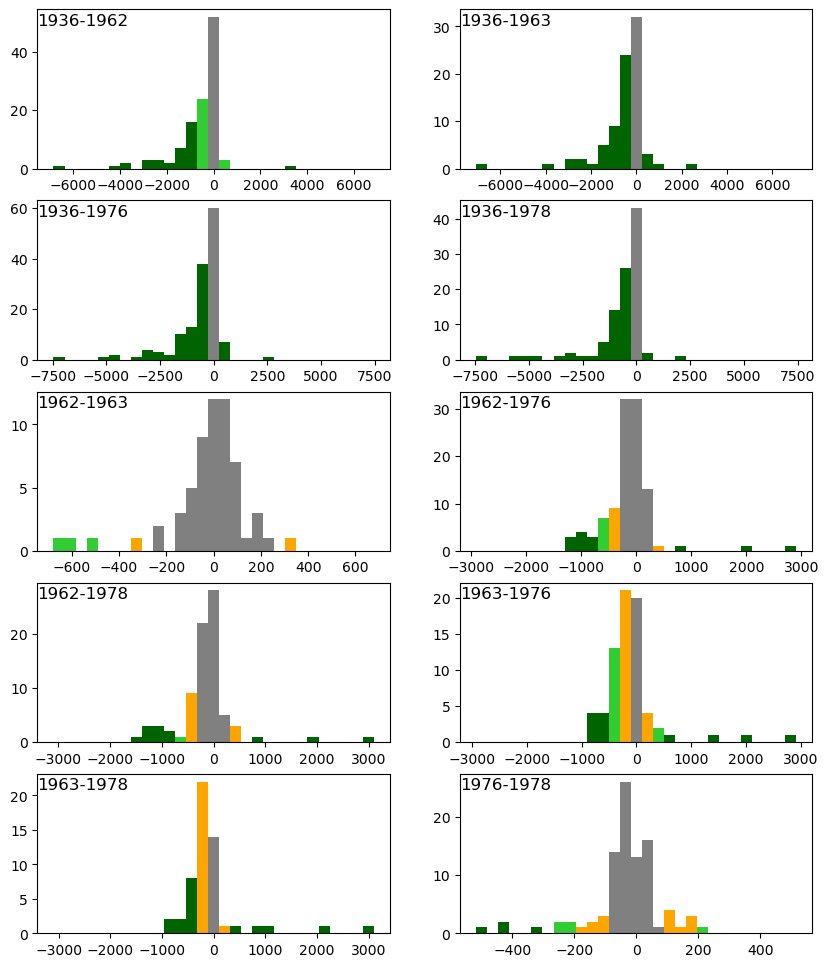

In [32]:
fig, axs = plt.subplots(ncols=2, nrows=5, figsize=(10, 12))

color_sigma = "orange"
color_2_sigma = "limegreen"
color_3_sigma = "darkgreen"
nbins = 30

years = (1936, 1962)
d = results_cl.loc[results_cl.years == years].mean_distance
N, bins, patches = axs[0, 0].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties_cl.loc[uncertainties_cl.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2  # shift bins to the center
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[0, 0].set_title(f"{years[0]}-{years[1]}", y=0.85, loc="left")
print(d.shape[0], d.mean(), d.std())

years = (1936, 1963)
d = results_cl.loc[results_cl.years == years].mean_distance
N, bins, patches = axs[0, 1].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties_cl.loc[uncertainties_cl.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2  # shift bins to the center
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[0, 1].set_title(f"{years[0]}-{years[1]}", y=0.85, loc="left")
print(d.shape[0], d.mean(), d.std())

years = (1936, 1976)
d = results_cl.loc[results_cl.years == years].mean_distance
N, bins, patches = axs[1, 0].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties_cl.loc[uncertainties_cl.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2  # shift bins to the center
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[1, 0].set_title(f"{years[0]}-{years[1]}", y=0.85, loc="left")
print(d.shape[0], d.mean(), d.std())

years = (1936, 1978)
d = results_cl.loc[results_cl.years == years].mean_distance
N, bins, patches = axs[1, 1].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties_cl.loc[uncertainties_cl.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2  # shift bins to the center
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[1, 1].set_title(f"{years[0]}-{years[1]}", y=0.85, loc="left")
print(d.shape[0], d.mean(), d.std())

years = (1962, 1963)
d = results_cl.loc[results_cl.years == years].mean_distance
N, bins, patches = axs[2, 0].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties_cl.loc[uncertainties_cl.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2  # shift bins to the center
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[2, 0].set_title(f"{years[0]}-{years[1]}", y=0.85, loc="left")
print(d.shape[0], d.mean(), d.std())
        
years = (1962, 1976)
d = results_cl.loc[results_cl.years == years].mean_distance
N, bins, patches = axs[2, 1].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties_cl.loc[uncertainties_cl.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[2, 1].set_title(f"{years[0]}-{years[1]}", y=0.85, loc="left")
print(d.shape[0], d.mean(), d.std())
        
years = (1962, 1978)
d = results_cl.loc[results_cl.years == years].mean_distance
N, bins, patches = axs[3, 0].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties_cl.loc[uncertainties_cl.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[3, 0].set_title(f"{years[0]}-{years[1]}", y=0.85, loc="left")
print(d.shape[0], d.mean(), d.std())
        
years = (1963, 1976)
d = results_cl.loc[results_cl.years == years].mean_distance
N, bins, patches = axs[3, 1].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties_cl.loc[uncertainties_cl.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[3, 1].set_title(f"{years[0]}-{years[1]}", y=0.85, loc="left")
print(d.shape[0], d.mean(), d.std())
        
years = (1963, 1978)
d = results_cl.loc[results_cl.years == years].mean_distance
N, bins, patches = axs[4, 0].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties_cl.loc[uncertainties_cl.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[4, 0].set_title(f"{years[0]}-{years[1]}", y=0.85, loc="left")
print(d.shape[0], d.mean(), d.std())
        
years = (1976, 1978)
d = results_cl.loc[results_cl.years == years].mean_distance
N, bins, patches = axs[4, 1].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties_cl.loc[uncertainties_cl.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[4, 1].set_title(f"{years[0]}-{years[1]}", y=0.85, loc="left")
print(d.shape[0], d.mean(), d.std())
# fig.savefig("images/results_distances_distributions_cl_with_NPI.png", bbox_inches="tight")

In [33]:
# list of surges and retreats

surges_cl = pd.DataFrame(
    [],
    columns=["front_id", "years", "mean_distance", "uncertainty"]
)

retreats_cl = pd.DataFrame(
    [],
    columns=["front_id", "years", "mean_distance", "uncertainty"]
)

for years in [(1936, 1962),
              (1936, 1963),
              (1936, 1976),
              (1936, 1978),
              (1962, 1963), 
              (1962, 1976), 
              (1962, 1978), 
              (1963, 1976), 
              (1963, 1978), 
              (1976, 1978)]:
    # print("years :", years)
    sigma = uncertainties_cl.loc[uncertainties_cl.years == years]["sigma_dist"].values[0]
    res = results_cl.where(results_cl.loc[results_cl.years == years, "mean_distance"].apply(lambda x: np.abs(x) >= 2 * sigma)).dropna().loc[:, ["front_id", "years", "mean_distance", "uncertainty"]]
    # print(res)
    surges_1 = res.where(res.mean_distance.apply(lambda x: x >= 0)).dropna()
    retreats_1 = res.where(res.mean_distance.apply(lambda x: x < 0)).dropna()
    if not surges_1.empty:
        surges_cl = pd.concat([surges_cl, surges_1])
    if not retreats_1.empty:
        retreats_cl = pd.concat([retreats_cl, retreats_1])
        
surges_cl

C:\Users\loris\AppData\Local\Temp\ipykernel_23148\776502126.py:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  surges_cl = pd.concat([surges_cl, surges_1])
C:\Users\loris\AppData\Local\Temp\ipykernel_23148\776502126.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  retreats_cl = pd.concat([retreats_cl, retreats_1])


,front_id,years,mean_distance,uncertainty
0,161,"(1936, 1962)",3183.115243,422.094776
189,172,"(1936, 1962)",462.573656,422.094776
401,4,"(1936, 1962)",470.262096,422.094776
1,161,"(1936, 1963)",2582.573822,229.869528
208,50,"(1936, 1963)",593.726217,229.869528
407,3,"(1936, 1963)",297.435920,229.869528
519,139,"(1936, 1963)",412.988529,229.869528
563,141,"(1936, 1963)",1020.138938,229.869528
2,161,"(1936, 1976)",2629.614304,173.170436
34,153,"(1936, 1976)",542.893951,173.170436


In [34]:
retreats_cl

,front_id,years,mean_distance,uncertainty
41,63,"(1936, 1962)",-2517.011643,422.094776
47,62,"(1936, 1962)",-4397.488108,422.094776
59,69,"(1936, 1962)",-943.442476,422.094776
74,68,"(1936, 1962)",-932.176232,422.094776
80,70,"(1936, 1962)",-723.708903,422.094776
...,...,...,...,...
152,93,"(1976, 1978)",-442.948674,195.509591
161,89,"(1976, 1978)",-516.365125,195.509591
167,61,"(1976, 1978)",-238.957585,195.509591
173,74,"(1976, 1978)",-335.299468,195.509591


In [35]:
# list of all fronts that either surged or retreated with >95% accuracy
len(surges_cl.front_id.unique()), surges_cl.front_id.unique(), len(retreats_cl.front_id.unique()), retreats_cl.front_id.unique()

(20,
 array([161, 172, 4, 50, 3, 139, 141, 153, 174, 125, 122, 123, 64, 56, 121,
        68, 120, 93, 92, 91], dtype=object),
 117,
 array([63, 62, 69, 68, 70, 100, 99, 98, 97, 96, 60, 61, 74, 105, 95, 180,
        75, 51, 52, 39, 31, 30, 14, 109, 111, 140, 106, 107, 108, 122, 120,
        123, 57, 56, 76, 42, 59, 58, 121, 138, 103, 101, 49, 93, 92, 41,
        54, 33, 27, 114, 115, 178, 94, 28, 46, 47, 48, 181, 91, 110, 150,
        152, 160, 73, 67, 66, 71, 72, 79, 65, 89, 90, 40, 53, 38, 34, 32,
        1, 4, 6, 5, 136, 112, 113, 142, 8, 9, 12, 37, 2, 15, 17, 19, 22,
        24, 35, 55, 78, 82, 88, 119, 143, 86, 80, 81, 83, 29, 127, 43, 84,
        116, 124, 145, 158, 161, 50, 141], dtype=object))

## Comparison methods

In [36]:
for i in results_cl.index.values:
    front_id, year1, year2 = results_cl.loc[i][["front_id", "year_1", "year_2"]]
    for j in results_box.index.values:
        front_id_2, year1_2, year2_2 = results_box.loc[j][["front_id", "year_1", "year_2"]]
        if (front_id == front_id_2) and (year1 == year1_2) and (year2 == year2_2):
            results_cl.loc[i, "mean_distance_2"] = results_box.loc[j, "mean_distance"]
            results_cl.loc[i, "uncertainty_2"] = results_box.loc[j, "uncertainty"]
            
results_cl

,front_id,year_1,year_2,years,distance,mean_distance,uncertainty,mean_distance_2,uncertainty_2
0,161,1936,1962,"(1936, 1962)","[2893.8148632743887, 3228.3994517792726, 3558....",3183.115243,422.094776,-530.152598,998.883377
1,161,1936,1963,"(1936, 1963)","[2755.7311611977148, 2409.416482499926]",2582.573822,229.869528,-1418.342903,430.055810
2,161,1936,1976,"(1936, 1976)","[3241.7178923552474, 2456.0261263823068, 2191....",2629.614304,173.170436,-1553.512480,194.586742
3,161,1936,1978,"(1936, 1978)",[2211.114313860473],2211.114314,108.461975,-1494.425580,200.449495
4,161,1962,1963,"(1962, 1963)","[-138.08370207667394, -484.39838077446257, -47...",-600.541422,476.944441,-888.190305,1085.904232
...,...,...,...,...,...,...,...,...,...
901,165,1962,1978,"(1962, 1978)","[-25.811142669132096, 80.97351549304221, -921....",-46.439776,431.740663,-121.758393,1017.064403
902,165,1976,1978,"(1976, 1978)","[125.30581528132825, 97.29998938744757]",111.302902,195.509591,292.585999,272.976189
903,166,1962,1978,"(1962, 1978)","[658.0198083298546, -38.50574296322884, -148.8...",-251.020222,431.740663,NaN,NaN
904,168,1962,1978,"(1962, 1978)","[414.8708733723761, -73.69857463817243, -776.6...",-198.476564,431.740663,-347.129713,1017.064403


In [37]:
results_cross = results_cl.loc[:, ["front_id", "year_1", "year_2", "years", "mean_distance", "mean_distance_2", "uncertainty", "uncertainty_2"]]
results_cross.columns = ["front_id", "year_1", "year_2", "years", "mean_distance_cl", "mean_distance_box", "uncertainty_cl", "uncertainty_box"]
results_cross.dropna(inplace=True)
results_cross

,front_id,year_1,year_2,years,mean_distance_cl,mean_distance_box,uncertainty_cl,uncertainty_box
0,161,1936,1962,"(1936, 1962)",3183.115243,-530.152598,422.094776,998.883377
1,161,1936,1963,"(1936, 1963)",2582.573822,-1418.342903,229.869528,430.055810
2,161,1936,1976,"(1936, 1976)",2629.614304,-1553.512480,173.170436,194.586742
3,161,1936,1978,"(1936, 1978)",2211.114314,-1494.425580,108.461975,200.449495
4,161,1962,1963,"(1962, 1963)",-600.541422,-888.190305,476.944441,1085.904232
...,...,...,...,...,...,...,...,...
900,165,1962,1976,"(1962, 1976)",-157.742678,-414.344392,452.353844,1015.925194
901,165,1962,1978,"(1962, 1978)",-46.439776,-121.758393,431.740663,1017.064403
902,165,1976,1978,"(1976, 1978)",111.302902,292.585999,195.509591,272.976189
904,168,1962,1978,"(1962, 1978)",-198.476564,-347.129713,431.740663,1017.064403


In [62]:
lr = scipy.stats.linregress(
    results_cross.mean_distance_cl,
    results_cross.mean_distance_box
)
lr.slope, lr.rvalue, lr.intercept

(1.8331271879519129, 0.8653318947712743, -183.70454223182918)

(-13365.027995039927, 7223.503727307754)


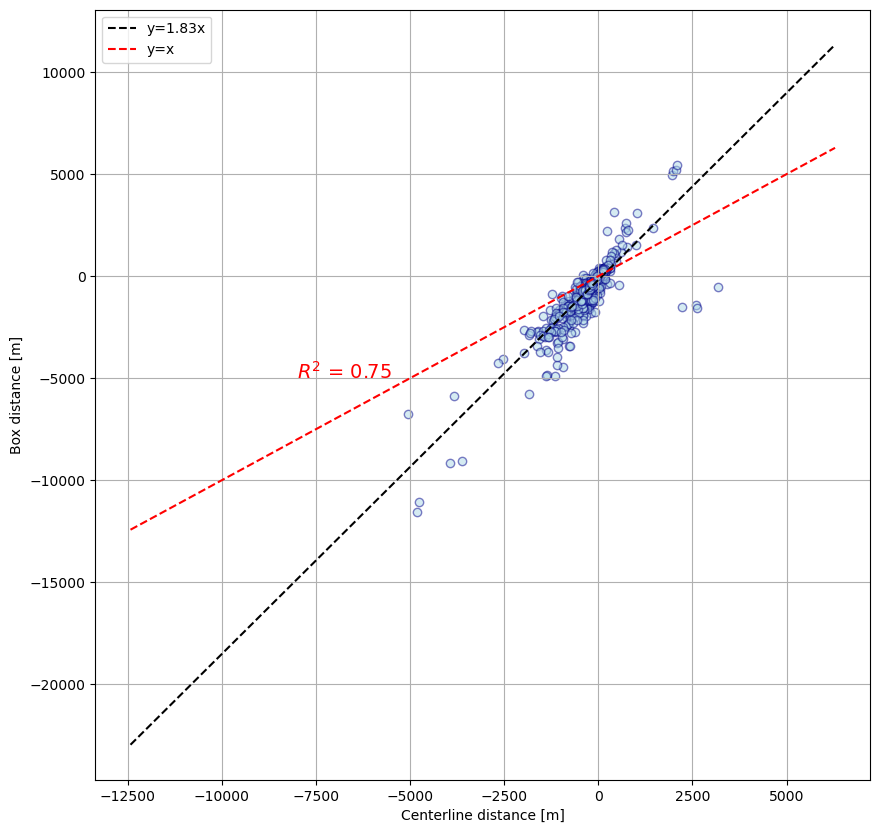

In [64]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(results_cross.mean_distance_cl, results_cross.mean_distance_box, color="lightblue", edgecolor="darkblue", alpha=0.5)

xlim = ax.get_xlim()
ylim = ax.get_ylim()
x_vals = np.linspace(min(xlim[0], ylim[0]), max(xlim[1], ylim[1]), 100)
ax.plot(x_vals, lr.slope * x_vals + lr.intercept, color ="k", linestyle="--", label=f"y={lr.slope:.2f}x")
ax.text(-8000, -5000, f"$R^2$ = {lr.rvalue**2:.2f}", fontsize=14, color="r")
ax.plot(x_vals, x_vals, color="r", linestyle="--", label="y=x")

ax.grid()
ax.legend()
ax.set_xlabel("Centerline distance [m]")
ax.set_ylabel("Box distance [m]")
print(ax.get_xlim())
fig.savefig("images/results_cross_distances.png", bbox_inches="tight")